In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/AN2DL/

/gdrive/My Drive/AN2DL


In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.utils import class_weight 
import pickle
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [4]:
# Random seed for reproducibility
seed = 73

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Common Functions

In [5]:
## Predict and Plot Confusion Matrix
def predict_plot_cm(model, x_test, test_labels):
  predictions = model.predict(x_test)
  # Compute the confusion matrix
  cm = confusion_matrix(np.argmax(test_labels, axis=-1), np.argmax(predictions, axis=-1))

  # Compute the classification metrics
  accuracy = accuracy_score(np.argmax(test_labels, axis=-1), np.argmax(predictions, axis=-1))
  precision = precision_score(np.argmax(test_labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  recall = recall_score(np.argmax(test_labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  f1 = f1_score(np.argmax(test_labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  print('Accuracy:',accuracy.round(4))
  print('Precision:',precision.round(4))
  print('Recall:',recall.round(4))
  print('F1:',f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=(10,8))
  sns.heatmap(cm.T, cmap='Blues', xticklabels=list(labels.keys()), yticklabels=list(labels.keys()), annot=True, fmt='')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()


## Plot training graph
def plot_training_history(history):
  best_epoch = np.argmax(history['val_accuracy'])
  plt.figure(figsize=(17,4))
  plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
  plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.title('Categorical Crossentropy')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

  plt.figure(figsize=(17,4))
  plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
  plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.title('Accuracy')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

  plt.figure(figsize=(17,4))
  plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

def reshape_array(data, labels):
  data_shape = data.shape
  labels_shape = labels.shape
  print('Input Data Shape:', data_shape)
  print('Input Labels Shape:', labels_shape)
  reshaped_data = np.zeros((data_shape[0] * data_shape[1], data_shape[2]))
  reshaped_labels = np.zeros((labels_shape[0] * data_shape[1], labels_shape[1]))
  element = 0
  for sample in range(data_shape[0]):
      for timestep in range(data_shape[1]):
          reshaped_data[element] = data[sample, timestep, :]
          reshaped_labels[element] = labels[sample, :]
          element += 1
  print('Reshaped Data:', reshaped_data.shape)
  print('Reshaped Labels:', reshaped_labels.shape)
  return reshaped_data, reshaped_labels

def restore_array_shape(data, labels):
  data_shape = data.shape
  labels_shape = labels.shape
  print('Input Data Shape:', data_shape)
  print('Input Labels Shape:', labels_shape)
  restored_data_shape = (data_shape[0]//36, 36, data_shape[1])
  restored_labels_shape = (labels_shape[0]//36, labels_shape[1])
  restored_data = np.zeros(restored_data_shape)
  restored_labels = np.zeros(restored_labels_shape)
  element = 0
  for sample in range(restored_data_shape[0]):
    for timestep in range(36):
      restored_data[sample, timestep, :] = data[element]
      restored_labels[sample, :] = labels[element]
      element += 1
  print('Restored Data:', restored_data.shape)
  print('Restored Labels:', restored_labels.shape)
  return restored_data, restored_labels


# Initialize and Load Data

In [5]:
## Load the data
x_data_array = np.load('x_train.npy')
y_data_array = np.load('y_train.npy')
# Convert sparse labels to categorical values
y_data_array_encoded = tfk.utils.to_categorical(y_data_array)
print(x_data_array.shape)
print(y_data_array_encoded.shape)

# Class label mapping
labels = {"Wish":0, "Another":1, "Comfortably":2, "Money":3, "Breathe":4, "Time":5, "Brain":6, "Echoes":7, "Wearing":8, "Sorrow":9, "Hey":10, "Shine":11}

(2429, 36, 6)
(2429, 12)


In [6]:
## Split the dataset
x_train, x_test, train_labels, test_labels = train_test_split(x_data_array, y_data_array_encoded, test_size=0.15, random_state=seed)
print(x_train.shape)
print(train_labels.shape)
print(x_test.shape)
print(test_labels.shape)

(2064, 36, 6)
(2064, 12)
(365, 36, 6)
(365, 12)


In [7]:
input_shape = x_train.shape[1:]
classes = len(labels)
batch_size = 128
epochs = 500

In [8]:
m_array = np.zeros((x_data_array.shape[0],x_data_array.shape[1],1))
for k in range(x_data_array.shape[0]):
  for i in range(x_data_array.shape[1]):
    m_array[k][i][0] = x_data_array[k][i].mean()

In [44]:
m_array.shape

(2429, 36, 1)

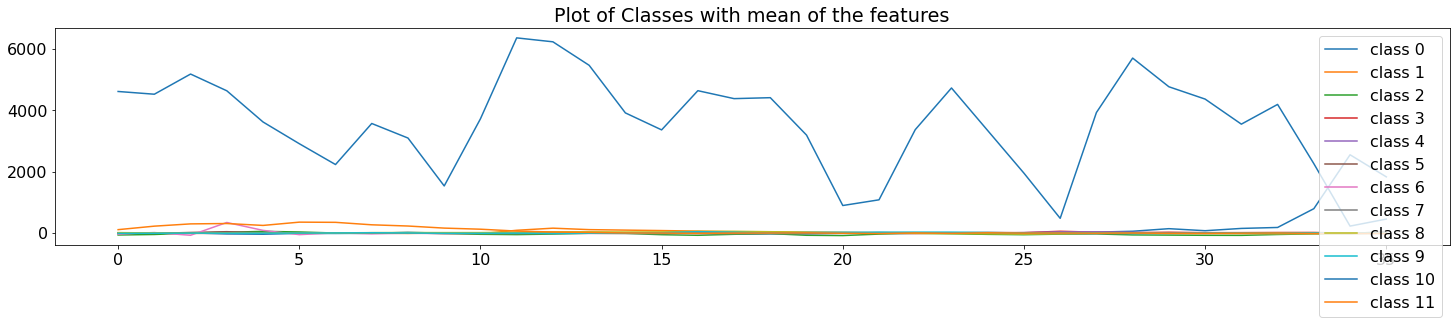

In [10]:
## Plot data
#c = np.concatenate((x_train[0],x_train[1]))
#g = x_train[9]
#print(g.mean())
#plt.plot(g)
#plt.plot(x_train[])
#print(train_labels[0:10])
plt.figure(figsize=(25,4))
for c in labels.values():
    c_x_train = m_array[y_data_array == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.title('Plot of Classes with mean of the features')
plt.show()
plt.close()

# LSTM Classifier

In [9]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128, kernel_regularizer=tf.keras.regularizers.l2(0.0001))(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(dropout)
    classifier = tfkl.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [18]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 36, 128)           69120     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 12)                780   

In [19]:
# Train the model
history = model.fit(
    x = x_train,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
16/16 [==============================] - 9s 61ms/step - loss: 2.2121 - accuracy: 0.2959 - val_loss: 1.9416 - val_accuracy: 0.3786 - lr: 0.0010
Epoch 2/500
16/16 [==============================] - 0s 15ms/step - loss: 1.8090 - accuracy: 0.4297 - val_loss: 1.6387 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 3/500
16/16 [==============================] - 0s 13ms/step - loss: 1.5517 - accuracy: 0.4941 - val_loss: 1.4388 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 4/500
16/16 [==============================] - 0s 12ms/step - loss: 1.3820 - accuracy: 0.5486 - val_loss: 1.3288 - val_accuracy: 0.5576 - lr: 0.0010
Epoch 5/500
16/16 [==============================] - 0s 12ms/step - loss: 1.2575 - accuracy: 0.5939 - val_loss: 1.2463 - val_accuracy: 0.5802 - lr: 0.0010
Epoch 6/500
16/16 [==============================] - 0s 11ms/step - loss: 1.1487 - accuracy: 0.6300 - val_loss: 1.2154 - val_accuracy: 0.6029 - lr: 0.0010
Epoch 7/500
16/16 [==============================] - 0s 12ms/step - lo

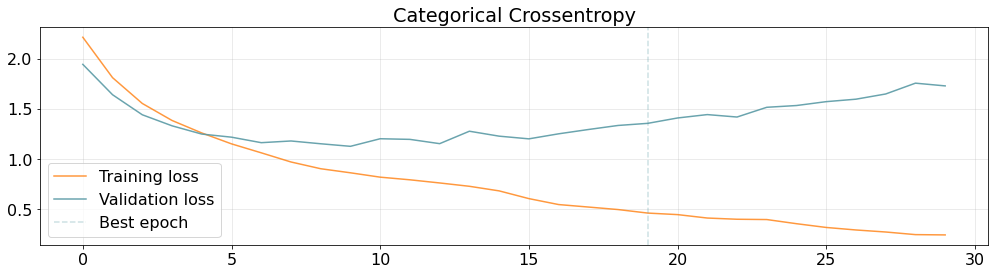

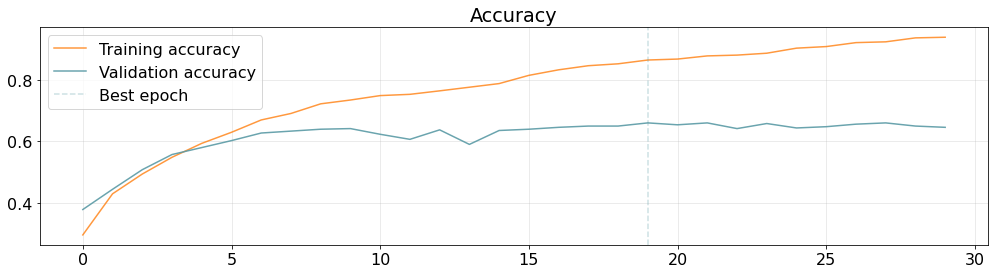

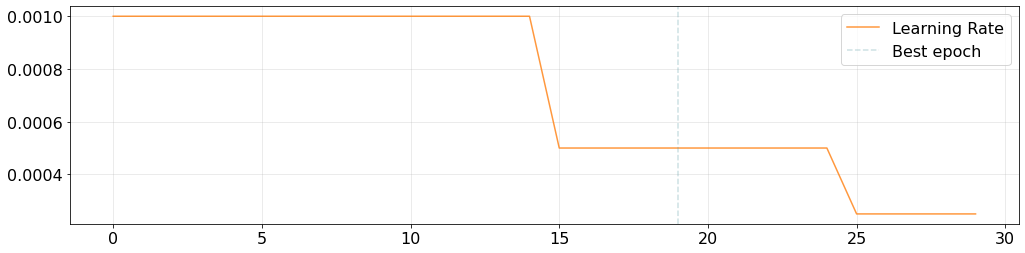

In [20]:
plot_training_history(history)

16/16 [==============================] - 1s 5ms/step
Accuracy: 0.6605
Precision: 0.7086
Recall: 0.544
F1: 0.5603


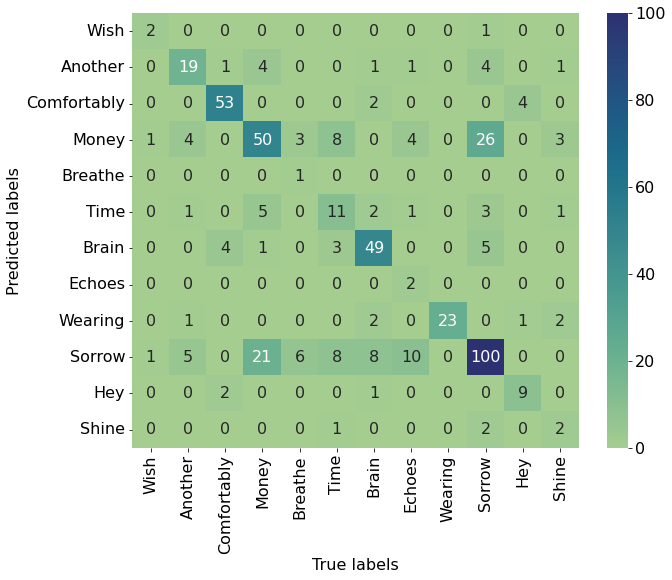

In [21]:
# Predict the test set with the LSTM
predict_plot_cm(model, x_test, test_labels)

In [ ]:
model.save('challenge2/LSTM_16_L2')

In [49]:
def build_LSTM_classifier_L1L2(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-4))(lstm)
    dropout = tfkl.Dropout(.8, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-4))(dropout)
    classifier = tfkl.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001))(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [58]:
L1L2_LSTM_model = build_LSTM_classifier_L1L2(input_shape, classes)
L1L2_LSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_8 (LSTM)               (None, 36, 128)           69120     
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 12)                780   

In [59]:
# Train the model
history = L1L2_LSTM_model.fit(
    x = x_train,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/500
16/16 [==============================] - 4s 61ms/step - loss: 2.7364 - accuracy: 0.2810 - val_loss: 2.5295 - val_accuracy: 0.3086 - lr: 0.0010
Epoch 2/500
16/16 [==============================] - 0s 12ms/step - loss: 2.4315 - accuracy: 0.3587 - val_loss: 2.3437 - val_accuracy: 0.3909 - lr: 0.0010
Epoch 3/500
16/16 [==============================] - 0s 13ms/step - loss: 2.2406 - accuracy: 0.4282 - val_loss: 2.0853 - val_accuracy: 0.4259 - lr: 0.0010
Epoch 4/500
16/16 [==============================] - 0s 11ms/step - loss: 2.0291 - accuracy: 0.4720 - val_loss: 1.9065 - val_accuracy: 0.4691 - lr: 0.0010
Epoch 5/500
16/16 [==============================] - 0s 11ms/step - loss: 1.8344 - accuracy: 0.5198 - val_loss: 1.7557 - val_accuracy: 0.5041 - lr: 0.0010
Epoch 6/500
16/16 [==============================] - 0s 12ms/step - loss: 1.7474 - accuracy: 0.5193 - val_loss: 1.7054 - val_accuracy: 0.5206 - lr: 0.0010
Epoch 7/500
16/16 [==============================] - 0s 11ms/step - lo

16/16 [==============================] - 1s 4ms/step
Accuracy: 0.6605
Precision: 0.5383
Recall: 0.514
F1: 0.5191


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


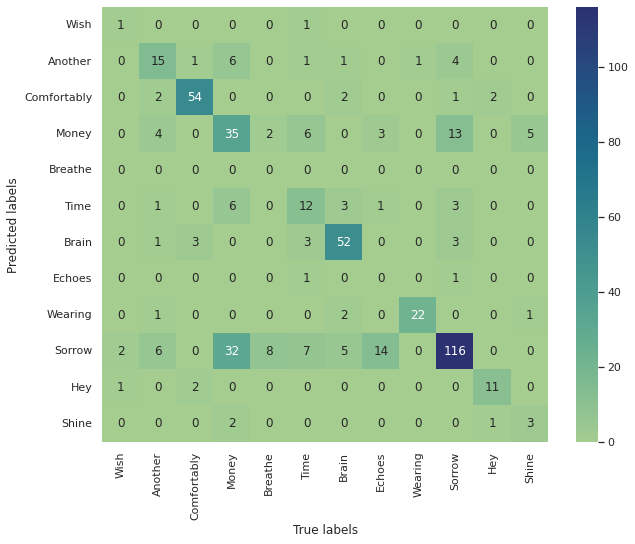

In [60]:
predict_plot_cm(L1L2_LSTM_model, x_test, test_labels)

#Scale Input

## MinMax Scaler

In [25]:
min_max_scaler = MinMaxScaler()
reshaped_x_train, restored_train_labels = reshape_array(x_train, train_labels)
reshaped_x_test, restored_test_labels = reshape_array(x_test, test_labels)
minmax_scaled_train = min_max_scaler.fit_transform(reshaped_x_train)
minmax_scaled_test = min_max_scaler.transform(reshaped_x_test)
scaled_train, train_labels = restore_array_shape(minmax_scaled_train, restored_train_labels)
scaled_test, test_labels = restore_array_shape(minmax_scaled_test, restored_test_labels)

Input Data Shape: (1943, 36, 6)
Input Labels Shape: (1943, 12)
Reshaped Data: (69948, 6)
Reshaped Labels: (69948, 12)
Input Data Shape: (486, 36, 6)
Input Labels Shape: (486, 12)
Reshaped Data: (17496, 6)
Reshaped Labels: (17496, 12)
Input Data Shape: (69948, 6)
Input Labels Shape: (69948, 12)
Restored Data: (1943, 36, 6)
Restored Labels: (1943, 12)
Input Data Shape: (17496, 6)
Input Labels Shape: (17496, 12)
Restored Data: (486, 36, 6)
Restored Labels: (486, 12)


In [26]:
scaled_train[0]

array([[0.09405348, 0.20694695, 0.21742302, 0.17379545, 0.15990552,
        0.12528824],
       [0.09390925, 0.20692142, 0.21745638, 0.17379897, 0.15989686,
        0.12509616],
       [0.09399429, 0.20694362, 0.21747461, 0.17374609, 0.15991227,
        0.1251398 ],
       [0.09403046, 0.20689838, 0.21746217, 0.17375144, 0.15987515,
        0.12520514],
       [0.09408094, 0.20693295, 0.21739108, 0.17374282, 0.15990336,
        0.12505846],
       [0.09420121, 0.20696728, 0.21742737, 0.17374651, 0.1599061 ,
        0.12522478],
       [0.09413129, 0.2069642 , 0.21745677, 0.17378462, 0.159851  ,
        0.12514051],
       [0.09412885, 0.20696424, 0.21739276, 0.17373404, 0.15987085,
        0.1249411 ],
       [0.09407114, 0.20704432, 0.21743767, 0.17375238, 0.15993417,
        0.12512058],
       [0.09400766, 0.20696753, 0.21740077, 0.17378908, 0.15998087,
        0.1249525 ],
       [0.09404376, 0.20693492, 0.21741856, 0.1737142 , 0.15994584,
        0.12495584],
       [0.09404113, 0

In [15]:
# Apply MinMax Scaler
min_max_scaler = MinMaxScaler()
minmax_scaled_train = min_max_scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
minmax_scaled_test = min_max_scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
minmax_scaled_train

array([[[0.09405348, 0.20694695, 0.21742302, 0.17379545, 0.15990552,
         0.12528824],
        [0.09390925, 0.20692142, 0.21745638, 0.17379897, 0.15989686,
         0.12509616],
        [0.09399429, 0.20694362, 0.21747461, 0.17374609, 0.15991227,
         0.1251398 ],
        ...,
        [0.09414346, 0.20695758, 0.21747268, 0.1737289 , 0.15985758,
         0.12516543],
        [0.09410848, 0.20698778, 0.2174452 , 0.17377093, 0.15993617,
         0.12513529],
        [0.09398976, 0.20697085, 0.21749467, 0.17384549, 0.15989588,
         0.12516871]],

       [[0.0993794 , 0.20776232, 0.21247142, 0.17453945, 0.15826873,
         0.12469851],
        [0.09926111, 0.20643239, 0.21486718, 0.17423283, 0.1597467 ,
         0.12426077],
        [0.09766478, 0.20477893, 0.21833389, 0.17375264, 0.16050523,
         0.12387353],
        ...,
        [0.09646762, 0.20710497, 0.21708459, 0.17370162, 0.16012301,
         0.12500621],
        [0.09549802, 0.20705627, 0.21674971, 0.17411844, 0.159

In [24]:
min_max_scaled_model = build_LSTM_classifier(input_shape, classes)
min_max_scaled_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 36, 128)           69120     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 12)                780   

In [28]:
# Train the model
history = min_max_scaled_model.fit(
    x = minmax_scaled_train,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(minmax_scaled_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
129/129 [==============================] - 3s 9ms/step - loss: 2.2353 - accuracy: 0.2926 - val_loss: 2.1154 - val_accuracy: 0.3123 - lr: 2.5000e-04
Epoch 2/500
129/129 [==============================] - 1s 8ms/step - loss: 2.1267 - accuracy: 0.3212 - val_loss: 2.1099 - val_accuracy: 0.3123 - lr: 2.5000e-04
Epoch 3/500
129/129 [==============================] - 1s 8ms/step - loss: 2.1193 - accuracy: 0.3212 - val_loss: 2.1128 - val_accuracy: 0.3123 - lr: 2.5000e-04
Epoch 4/500
129/129 [==============================] - 1s 8ms/step - loss: 2.1144 - accuracy: 0.3212 - val_loss: 2.1111 - val_accuracy: 0.3123 - lr: 2.5000e-04
Epoch 5/500
129/129 [==============================] - 1s 8ms/step - loss: 2.1147 - accuracy: 0.3212 - val_loss: 2.1133 - val_accuracy: 0.3123 - lr: 2.5000e-04
Epoch 6/500
129/129 [==============================] - 1s 8ms/step - loss: 2.1156 - accuracy: 0.3212 - val_loss: 2.1160 - val_accuracy: 0.3123 - lr: 2.5000e-04
Epoch 7/500
129/129 [===================

12/12 [==============================] - 1s 4ms/step
Accuracy: 0.3123
Precision: 0.026
Recall: 0.0833
F1: 0.0397


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


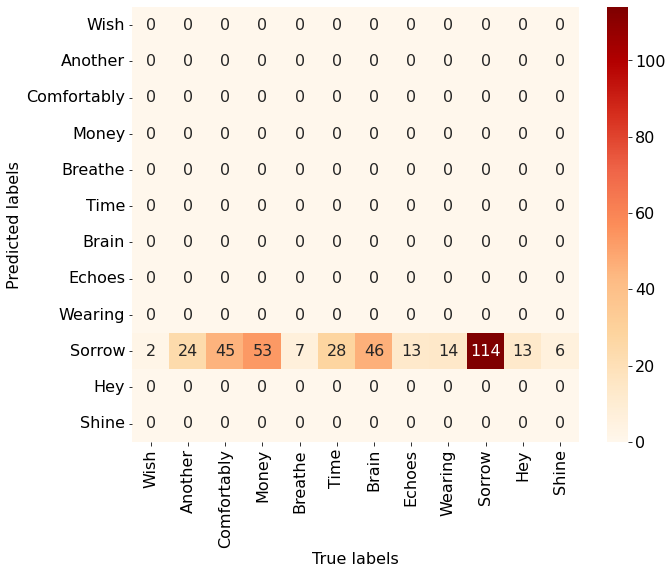

In [21]:
predict_plot_cm(min_max_scaled_model, minmax_scaled_test, test_labels)

In [32]:
new_x_train = x_train
new_x_test = x_test
scalers = {}
for i in range(new_x_train.shape[1]):
    scalers[i] = MinMaxScaler()
    new_x_train[:, i, :] = scalers[i].fit_transform(new_x_train[:, i, :]) 

for i in range(new_x_test.shape[1]):
    new_x_test[:, i, :] = scalers[i].transform(new_x_test[:, i, :]) 
new_x_train

array([[[0.36064039, 0.32325363, 0.42193708, 0.45089742, 0.56226556,
         0.35616843],
        [0.16591663, 0.37019909, 0.40082318, 0.50690307, 0.46023257,
         0.41118259],
        [0.09226613, 0.38696749, 0.26696439, 0.47429109, 0.36690356,
         0.36123415],
        ...,
        [0.0940726 , 0.19329396, 0.1919173 , 0.12317724, 0.11608258,
         0.12529198],
        [0.11483578, 0.20869675, 0.20896836, 0.15317816, 0.10886077,
         0.15467291],
        [0.23518143, 0.22417771, 0.18234238, 0.13486005, 0.13548975,
         0.15188531]],

       [[0.43127105, 0.32525006, 0.40754103, 0.4545579 , 0.55412678,
         0.3532343 ],
        [0.19523235, 0.36907815, 0.39348975, 0.50848682, 0.45954476,
         0.40653131],
        [0.10316874, 0.38187684, 0.26885508, 0.47432393, 0.36931738,
         0.35495916],
        ...,
        [0.09924572, 0.1934883 , 0.19145968, 0.12314501, 0.1164025 ,
         0.12503731],
        [0.11822176, 0.20880353, 0.20809676, 0.15363358, 0.108

In [40]:
minmax_bilstm_model = build_BiLSTM_classifier(input_shape, classes)
minmax_bilstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 12)                780   

In [41]:
# Train the model
history = minmax_bilstm_model.fit(
    x = new_x_train,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    class_weight = class_weights_dict,
    validation_data=(new_x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
16/16 [==============================] - 8s 113ms/step - loss: 2.5151 - accuracy: 0.0551 - val_loss: 2.4835 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 2/500
16/16 [==============================] - 0s 20ms/step - loss: 2.5107 - accuracy: 0.0798 - val_loss: 2.4883 - val_accuracy: 0.1337 - lr: 0.0010
Epoch 3/500
16/16 [==============================] - 0s 20ms/step - loss: 2.5082 - accuracy: 0.1312 - val_loss: 2.5119 - val_accuracy: 0.0206 - lr: 0.0010
Epoch 4/500
16/16 [==============================] - 0s 20ms/step - loss: 2.5065 - accuracy: 0.0978 - val_loss: 2.4867 - val_accuracy: 0.0082 - lr: 0.0010
Epoch 5/500
16/16 [==============================] - 0s 19ms/step - loss: 2.5035 - accuracy: 0.0659 - val_loss: 2.5000 - val_accuracy: 0.0082 - lr: 0.0010
Epoch 6/500
16/16 [==============================] - 0s 19ms/step - loss: 2.5059 - accuracy: 0.0381 - val_loss: 2.5006 - val_accuracy: 0.0082 - lr: 0.0010
Epoch 7/500
16/16 [==============================] - 0s 20ms/step - l

16/16 [==============================] - 2s 7ms/step
Accuracy: 0.1667
Precision: 0.0139
Recall: 0.0833
F1: 0.0238


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


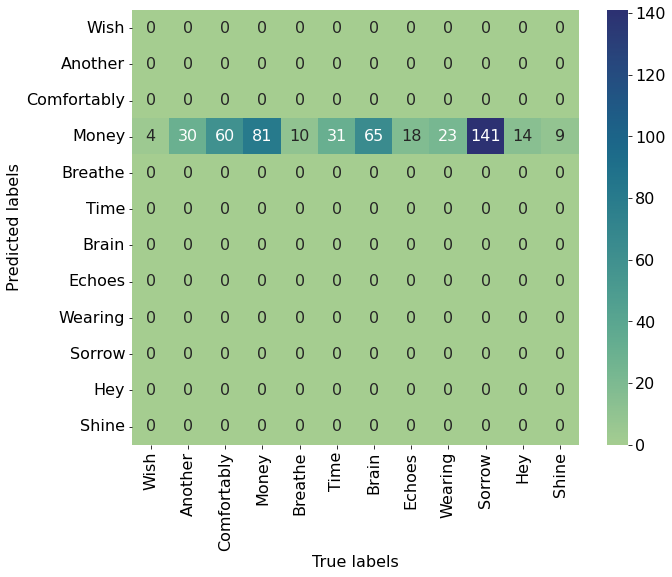

In [43]:
predict_plot_cm(minmax_bilstm_model, new_x_test, test_labels)

## Standard Scaler

In [67]:
standard_scaler = StandardScaler()
standard_scaled_train = standard_scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
standard_scaled_test = standard_scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
standard_scaled_train

array([[[ 3.91495037e-02, -4.71863079e-03, -6.87563197e-02,
          2.92119097e-02, -3.79773062e-02,  6.62024802e-02],
        [ 1.00403126e-01, -3.05028673e-02,  1.58925326e-02,
          5.00809806e-02, -2.26802838e-02, -2.04905925e-02],
        [ 1.07493432e-01, -4.08889677e-02,  6.48636199e-04,
         -2.70163051e-02,  6.39702204e-02, -5.97937523e-02],
        ...,
        [-6.90386336e-02, -1.10706751e-02, -1.00779229e-01,
         -8.80311497e-02, -1.97506325e-02, -1.44282643e-01],
        [-5.21788338e-02,  5.70250630e-04, -1.31078575e-01,
         -1.20559593e-01,  8.03588689e-05, -9.82557301e-02],
        [-4.06209573e-02, -4.97668612e-03, -9.93238401e-02,
         -9.93761767e-02, -6.45341213e-02, -4.35883810e-02]],

       [[-2.12347655e-02, -1.52733440e-02, -1.69245288e-03,
         -4.95380730e-02, -1.01335717e-01,  9.03774728e-03],
        [-6.88719136e-02, -1.75058984e-02, -1.72480113e-02,
         -5.32084576e-02, -2.29325330e-03, -5.45051413e-02],
        [-1.21037

In [71]:
standard_scaled_model = build_BiLSTM_classifier(input_shape, classes)
standard_scaled_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 64)                16448     
                                                                 
 dense_31 (Dense)            (None, 12)                780   

In [72]:
# Train the model
history = standard_scaled_model.fit(
    x = standard_scaled_train,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(standard_scaled_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/500
17/17 [==============================] - 6s 103ms/step - loss: 2.3166 - accuracy: 0.3144 - val_loss: 2.0549 - val_accuracy: 0.3562 - lr: 0.0010
Epoch 2/500
17/17 [==============================] - 0s 19ms/step - loss: 1.9969 - accuracy: 0.3580 - val_loss: 1.9262 - val_accuracy: 0.3479 - lr: 0.0010
Epoch 3/500
17/17 [==============================] - 0s 17ms/step - loss: 1.8618 - accuracy: 0.3905 - val_loss: 1.8350 - val_accuracy: 0.3808 - lr: 0.0010
Epoch 4/500
17/17 [==============================] - 0s 18ms/step - loss: 1.8137 - accuracy: 0.3953 - val_loss: 1.7189 - val_accuracy: 0.4247 - lr: 0.0010
Epoch 5/500
17/17 [==============================] - 0s 18ms/step - loss: 1.7047 - accuracy: 0.4307 - val_loss: 1.6291 - val_accuracy: 0.4356 - lr: 0.0010
Epoch 6/500
17/17 [==============================] - 0s 18ms/step - loss: 1.6462 - accuracy: 0.4559 - val_loss: 1.6095 - val_accuracy: 0.4740 - lr: 0.0010
Epoch 7/500
17/17 [==============================] - 0s 18ms/step - l

12/12 [==============================] - 1s 6ms/step
Accuracy: 0.589
Precision: 0.4559
Recall: 0.442
F1: 0.4421


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


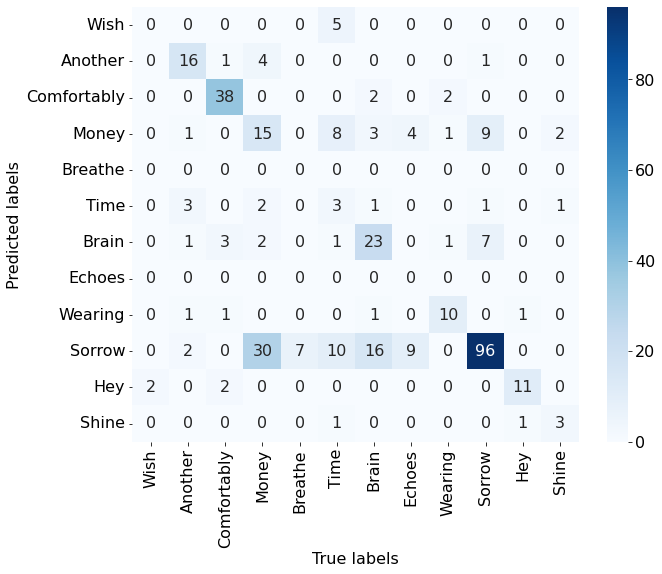

In [73]:
predict_plot_cm(standard_scaled_model, standard_scaled_test, test_labels)

## Robust Scaler

In [ ]:
robust_scaler = RobustScaler()
robust_scaled_train = robust_scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
robust_scaled_test = robust_scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
robust_scaled_train

array([[[ 0.35047729, -0.08863932,  0.24744943,  0.6653303 ,
          1.0363078 ,  0.2041463 ],
        [-0.40484915,  0.18275025,  0.13519327,  0.9535697 ,
          0.62806487,  0.4007866 ],
        [-0.700394  ,  0.27901506, -0.72110438,  0.76815311,
          0.26951285,  0.19858405],
        ...,
        [-0.70903912, -0.85559617, -1.21183922, -1.05832357,
         -0.76655096, -0.71199672],
        [-0.62777292, -0.76354339, -1.1073248 , -0.90683514,
         -0.79516211, -0.59630298],
        [-0.16200147, -0.67207869, -1.27492684, -1.00061801,
         -0.6915004 , -0.60267824]],

       [[ 0.32791643, -0.09080765,  0.26549984,  0.63795356,
          1.01903291,  0.19149428],
        [-0.43097209,  0.18524988,  0.12650361,  0.92692835,
          0.63318544,  0.39236202],
        [-0.71951828,  0.28305132, -0.72932075,  0.76026241,
          0.23989274,  0.19722444],
        ...,
        [-0.7066103 , -0.853752  , -1.2048466 , -1.05421089,
         -0.76958626, -0.71176392],
  

In [ ]:
# Train the model
history = model.fit(
    x = robust_scaled_train,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(robust_scaled_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
129/129 [==============================] - 9s 67ms/step - loss: 2.1282 - accuracy: 0.3110 - val_loss: 2.0803 - val_accuracy: 0.3151 - lr: 1.0000e-05
Epoch 2/500
129/129 [==============================] - 9s 67ms/step - loss: 2.0988 - accuracy: 0.3227 - val_loss: 2.0756 - val_accuracy: 0.3178 - lr: 1.0000e-05
Epoch 3/500
129/129 [==============================] - 9s 67ms/step - loss: 2.0945 - accuracy: 0.3232 - val_loss: 2.0726 - val_accuracy: 0.3178 - lr: 1.0000e-05
Epoch 4/500
129/129 [==============================] - 9s 68ms/step - loss: 2.0868 - accuracy: 0.3256 - val_loss: 2.0687 - val_accuracy: 0.3178 - lr: 1.0000e-05
Epoch 5/500
129/129 [==============================] - 9s 67ms/step - loss: 2.0826 - accuracy: 0.3275 - val_loss: 2.0645 - val_accuracy: 0.3178 - lr: 1.0000e-05
Epoch 6/500
129/129 [==============================] - 9s 73ms/step - loss: 2.0777 - accuracy: 0.3256 - val_loss: 2.0591 - val_accuracy: 0.3233 - lr: 1.0000e-05
Epoch 7/500
129/129 [=============

12/12 [==============================] - 1s 44ms/step
Accuracy: 0.3315
Precision: 0.0756
Recall: 0.1282
F1: 0.0874


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


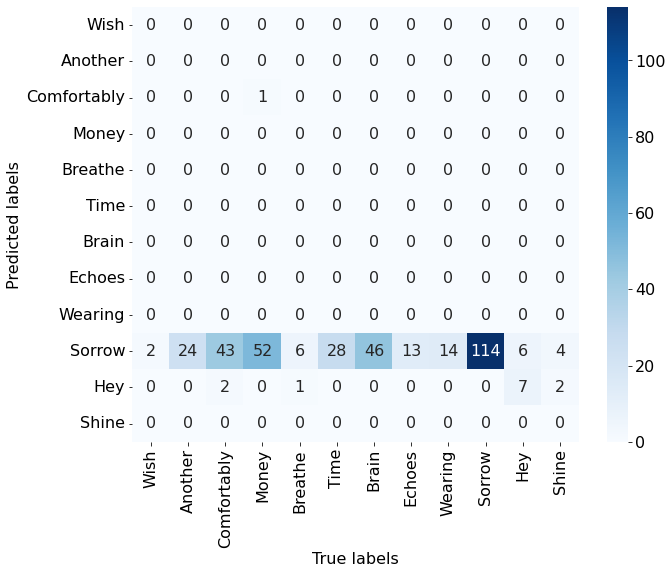

In [ ]:
predict_plot_cm(model, robust_scaled_test, test_labels)

## Power Transform

In [54]:
# Power Transform
from sklearn.preprocessing import PowerTransformer
power_transformer = PowerTransformer()
pt_train = power_transformer.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
pt_test = power_transformer.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
pt_train

array([[[ 1.23319467e-01,  1.88790600e-02, -4.33489265e-02,
          6.94582255e-02,  1.48204102e-02,  1.26567903e-01],
        [ 1.88912832e-01, -7.62371721e-03,  4.48055191e-02,
          8.93569194e-02,  3.10894916e-02,  3.75527325e-02],
        [ 1.96305969e-01, -1.90503039e-02,  3.01041746e-02,
          1.44439534e-02,  1.17381311e-01, -1.33894435e-02],
        ...,
        [-2.24092593e-02,  1.26204095e-02, -8.07066049e-02,
         -5.72635136e-02,  3.41411436e-02, -1.55739966e-01],
        [ 7.34042394e-03,  2.40486426e-02, -1.16527242e-01,
         -9.96299816e-02,  5.44440578e-02, -7.63398544e-02],
        [ 2.64269728e-02,  1.86259826e-02, -7.89958028e-02,
         -7.19256406e-02, -1.81715781e-02,  1.07611574e-02]],

       [[ 5.31664902e-02,  8.43446078e-03,  2.78332445e-02,
         -9.27721965e-03, -7.24654688e-02,  6.88856896e-02],
        [-2.21075128e-02,  6.18711798e-03,  1.26203297e-02,
         -1.36182981e-02,  5.20411935e-02, -5.20623540e-03],
        [-1.21105

In [57]:
pt_model = build_LSTM_classifier(input_shape, classes)
pt_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 36, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 12)                780   

In [58]:
# Train the model
history = pt_model.fit(
    x = pt_train,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(pt_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
129/129 [==============================] - 13s 73ms/step - loss: 2.0963 - accuracy: 0.3479 - val_loss: 1.9106 - val_accuracy: 0.3699 - lr: 0.0010
Epoch 2/500
129/129 [==============================] - 8s 66ms/step - loss: 1.8966 - accuracy: 0.3769 - val_loss: 1.8097 - val_accuracy: 0.3945 - lr: 0.0010
Epoch 3/500
129/129 [==============================] - 8s 65ms/step - loss: 1.8174 - accuracy: 0.3992 - val_loss: 1.8787 - val_accuracy: 0.3534 - lr: 0.0010
Epoch 4/500
129/129 [==============================] - 8s 65ms/step - loss: 1.7632 - accuracy: 0.4123 - val_loss: 1.7746 - val_accuracy: 0.3836 - lr: 0.0010
Epoch 5/500
129/129 [==============================] - 8s 65ms/step - loss: 1.7445 - accuracy: 0.4191 - val_loss: 1.7193 - val_accuracy: 0.4027 - lr: 0.0010
Epoch 6/500
129/129 [==============================] - 8s 64ms/step - loss: 1.7174 - accuracy: 0.4172 - val_loss: 1.7499 - val_accuracy: 0.3973 - lr: 0.0010
Epoch 7/500
129/129 [==============================] - 8s

12/12 [==============================] - 2s 90ms/step
Accuracy: 0.6411
Precision: 0.5375
Recall: 0.4596
F1: 0.4653


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


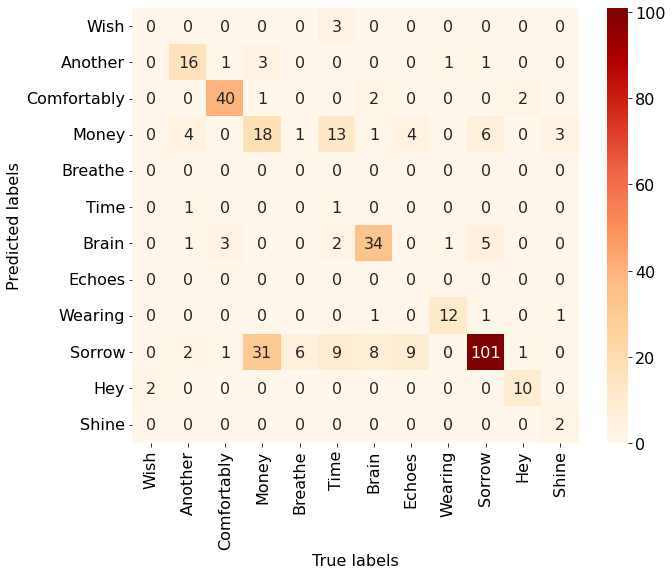

In [59]:
predict_plot_cm(pt_model, pt_test, test_labels)

# Class Distribution

{0: 34, 1: 123, 2: 270, 3: 381, 4: 62, 5: 153, 6: 313, 7: 68, 8: 120, 9: 777, 10: 77, 11: 51}


([<matplotlib.axis.XTick at 0x7fd0f42220a0>,
 <a list of 12 Text major ticklabel objects>)

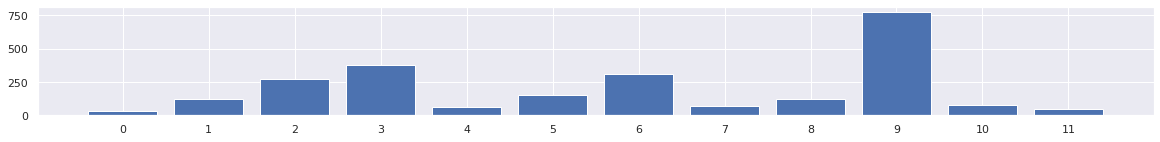

In [53]:
data, counts_data = np.unique(np.load('y_train.npy'), return_counts=True)
class_freq = dict(zip(data, counts_data))
print(class_freq)
plt.bar(list(class_freq.keys()),list(class_freq.values()))
plt.xticks(np.arange(12))

dict_items([(0, 34), (1, 123), (2, 270), (3, 381), (4, 62), (5, 153), (6, 313), (7, 68), (8, 120), (9, 777), (10, 77), (11, 51)])


([<matplotlib.axis.XTick at 0x7f2c2baa73a0>,
 <a list of 12 Text major ticklabel objects>)

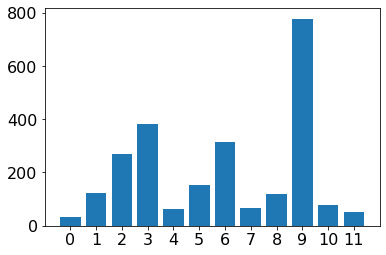

In [ ]:
counter = Counter(np.load('y_train.npy'))
print(counter.items())
plt.bar(list(counter.keys()),list(counter.values()))
plt.xticks(np.arange(12))

# Generating Class Weights

In [39]:
# Generate class weights
class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
            classes=np.unique(np.load('y_train.npy')), 
            y=np.load('y_train.npy'))
class_weights_dict = dict(zip(np.unique(np.load('y_train.npy')), class_weights))
class_weights_dict

{0: 5.953431372549019,
 1: 1.6456639566395663,
 2: 0.7496913580246913,
 3: 0.5312773403324584,
 4: 3.264784946236559,
 5: 1.3229847494553377,
 6: 0.6466986155484558,
 7: 2.9767156862745097,
 8: 1.6868055555555554,
 9: 0.2605105105105105,
 10: 2.628787878787879,
 11: 3.968954248366013}

In [46]:
cw_lstm_model = build_LSTM_classifier(input_shape, classes)
cw_lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_18 (LSTM)              (None, 36, 128)           69120     
                                                                 
 lstm_19 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 12)                780   

In [47]:
# Train the model
history = cw_lstm_model.fit(
    x = x_train,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    class_weight = class_weights_dict,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
129/129 [==============================] - 5s 14ms/step - loss: 2.2365 - accuracy: 0.1856 - val_loss: 1.9994 - val_accuracy: 0.2027 - lr: 0.0010
Epoch 2/500
129/129 [==============================] - 1s 8ms/step - loss: 1.8511 - accuracy: 0.2277 - val_loss: 1.9629 - val_accuracy: 0.2740 - lr: 0.0010
Epoch 3/500
129/129 [==============================] - 1s 8ms/step - loss: 1.6480 - accuracy: 0.3309 - val_loss: 1.8107 - val_accuracy: 0.3096 - lr: 0.0010
Epoch 4/500
129/129 [==============================] - 1s 9ms/step - loss: 1.5274 - accuracy: 0.3222 - val_loss: 1.7869 - val_accuracy: 0.2904 - lr: 0.0010
Epoch 5/500
129/129 [==============================] - 1s 8ms/step - loss: 1.3770 - accuracy: 0.3905 - val_loss: 1.7208 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 6/500
129/129 [==============================] - 1s 8ms/step - loss: 1.2474 - accuracy: 0.3997 - val_loss: 1.6438 - val_accuracy: 0.3616 - lr: 0.0010
Epoch 7/500
129/129 [==============================] - 1s 8ms/s

12/12 [==============================] - 1s 4ms/step
Accuracy: 0.6795
Precision: 0.6203
Recall: 0.649
F1: 0.6286


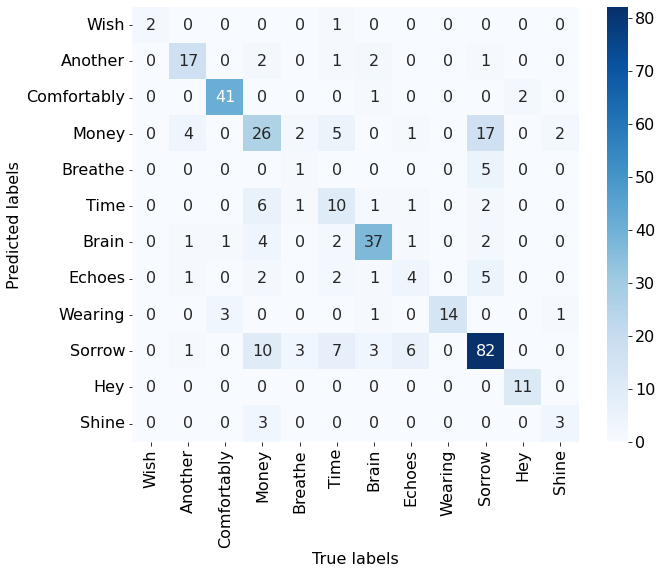

In [48]:
predict_plot_cm(cw_lstm_model, x_test, test_labels)

In [49]:
# Save the model
cw_lstm_model.save('challenge2/LSTM_16_L2_CW')

# BiDirectional LSTM

In [10]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(dropout)
    classifier = tfkl.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [54]:
bilstm_model = build_BiLSTM_classifier(input_shape, classes)
bilstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                16448     
                                                                 
 dense_25 (Dense)            (None, 12)                780   

In [55]:
# Train the model
history = bilstm_model.fit(
    x = x_train,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    #class_weight = class_weights_dict,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
129/129 [==============================] - 9s 27ms/step - loss: 1.6591 - accuracy: 0.4569 - val_loss: 1.2985 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 2/500
129/129 [==============================] - 2s 13ms/step - loss: 1.2050 - accuracy: 0.5993 - val_loss: 1.0981 - val_accuracy: 0.6192 - lr: 0.0010
Epoch 3/500
129/129 [==============================] - 2s 13ms/step - loss: 1.0614 - accuracy: 0.6361 - val_loss: 1.0709 - val_accuracy: 0.6274 - lr: 0.0010
Epoch 4/500
129/129 [==============================] - 2s 13ms/step - loss: 0.9123 - accuracy: 0.6914 - val_loss: 1.1190 - val_accuracy: 0.6274 - lr: 0.0010
Epoch 5/500
129/129 [==============================] - 2s 13ms/step - loss: 0.8283 - accuracy: 0.7209 - val_loss: 1.0434 - val_accuracy: 0.6411 - lr: 0.0010
Epoch 6/500
129/129 [==============================] - 2s 13ms/step - loss: 0.7870 - accuracy: 0.7452 - val_loss: 1.1276 - val_accuracy: 0.6082 - lr: 0.0010
Epoch 7/500
129/129 [==============================] - 2s 

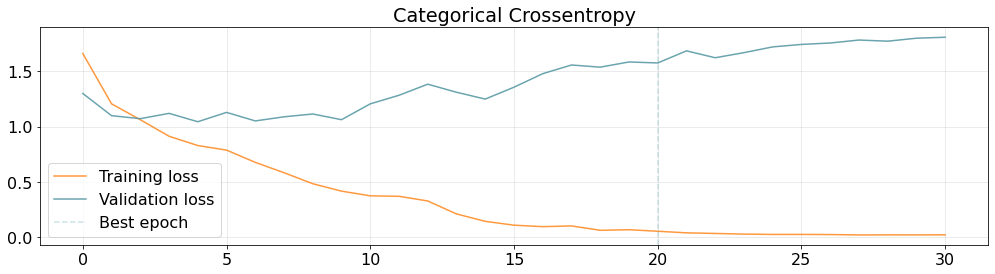

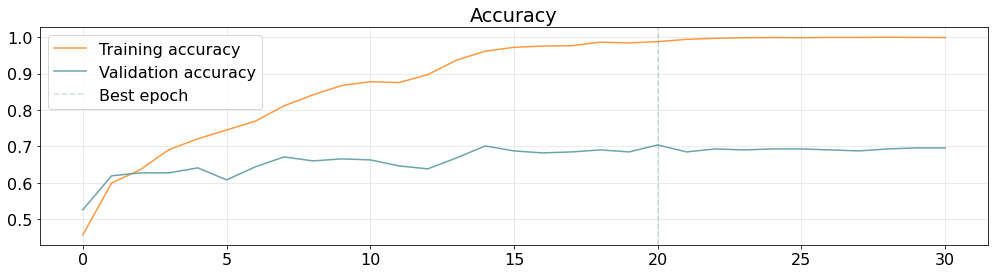

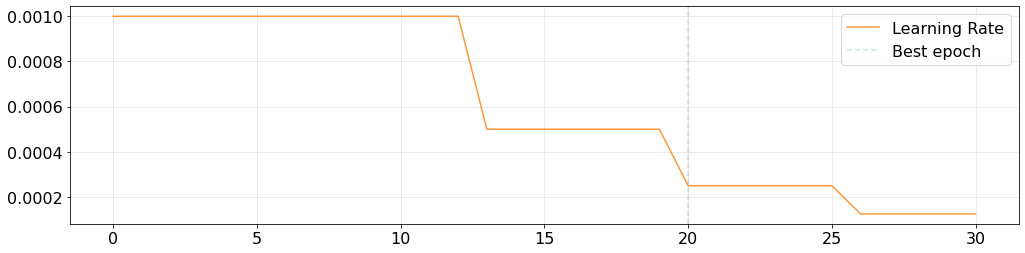

In [56]:
plot_training_history(history)

12/12 [==============================] - 2s 6ms/step
Accuracy: 0.7041
Precision: 0.6767
Recall: 0.631
F1: 0.642


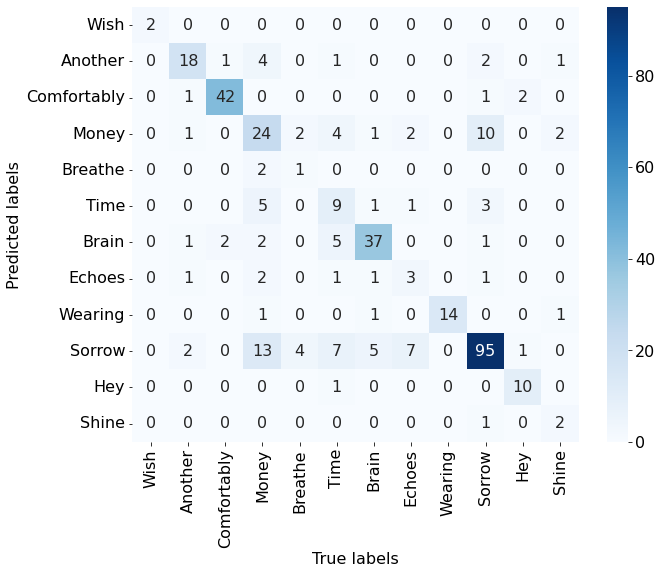

In [57]:
predict_plot_cm(bilstm_model, x_test, test_labels)

In [61]:
bilstm_model.save('challenge2/BiLSTM_16_L2')

In [58]:
# Try with class weights
cw_bilstm_model = build_BiLSTM_classifier(input_shape, classes)
cw_bilstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                16448     
                                                                 
 dense_28 (Dense)            (None, 12)                780   

In [59]:
# Train the model
history = cw_bilstm_model.fit(
    x = x_train,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    class_weight = class_weights_dict,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
129/129 [==============================] - 8s 26ms/step - loss: 2.0738 - accuracy: 0.2597 - val_loss: 1.8002 - val_accuracy: 0.2411 - lr: 0.0010
Epoch 2/500
129/129 [==============================] - 2s 13ms/step - loss: 1.5203 - accuracy: 0.3367 - val_loss: 1.5622 - val_accuracy: 0.3589 - lr: 0.0010
Epoch 3/500
129/129 [==============================] - 2s 13ms/step - loss: 1.2613 - accuracy: 0.4264 - val_loss: 1.6115 - val_accuracy: 0.3425 - lr: 0.0010
Epoch 4/500
129/129 [==============================] - 2s 13ms/step - loss: 1.0925 - accuracy: 0.4453 - val_loss: 1.6458 - val_accuracy: 0.3863 - lr: 0.0010
Epoch 5/500
129/129 [==============================] - 2s 13ms/step - loss: 0.9642 - accuracy: 0.4782 - val_loss: 1.3825 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 6/500
129/129 [==============================] - 2s 13ms/step - loss: 0.8737 - accuracy: 0.5039 - val_loss: 1.5488 - val_accuracy: 0.4301 - lr: 0.0010
Epoch 7/500
129/129 [==============================] - 2s 

12/12 [==============================] - 1s 7ms/step
Accuracy: 0.6329
Precision: 0.6004
Recall: 0.6444
F1: 0.6


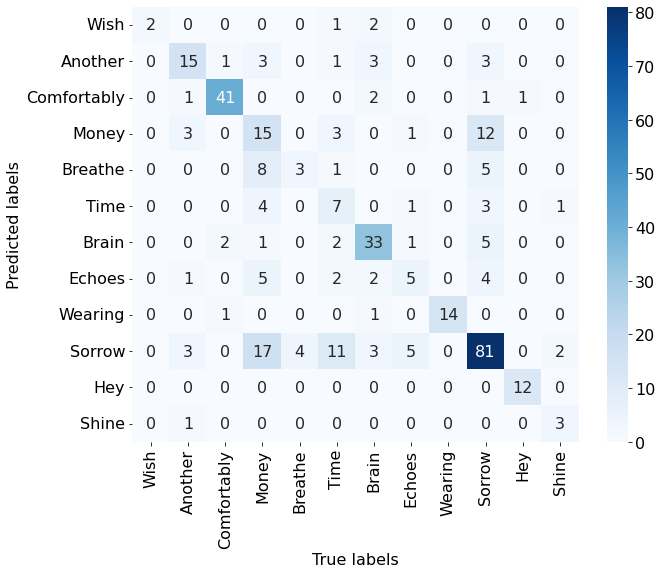

In [60]:
predict_plot_cm(cw_bilstm_model, x_test, test_labels)

# 1DCNN

In [11]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(dropout)
    classifier = tfkl.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [55]:
CNN1D_model = build_1DCNN_classifier(input_shape, classes)
CNN1D_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 36, 128)           2432      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 18, 128)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 global_average_pooling1d_3   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 128)               0     

In [56]:
# Train the model
history = CNN1D_model.fit(
    x = x_train,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
16/16 [==============================] - 1s 18ms/step - loss: 19.0726 - accuracy: 0.0834 - val_loss: 8.3138 - val_accuracy: 0.1831 - lr: 0.0010
Epoch 2/500
16/16 [==============================] - 0s 7ms/step - loss: 9.4686 - accuracy: 0.1508 - val_loss: 3.6746 - val_accuracy: 0.2469 - lr: 0.0010
Epoch 3/500
16/16 [==============================] - 0s 7ms/step - loss: 5.7099 - accuracy: 0.1786 - val_loss: 3.3694 - val_accuracy: 0.3765 - lr: 0.0010
Epoch 4/500
16/16 [==============================] - 0s 8ms/step - loss: 4.3162 - accuracy: 0.2136 - val_loss: 3.3385 - val_accuracy: 0.2654 - lr: 0.0010
Epoch 5/500
16/16 [==============================] - 0s 6ms/step - loss: 3.6160 - accuracy: 0.2486 - val_loss: 2.8638 - val_accuracy: 0.2942 - lr: 0.0010
Epoch 6/500
16/16 [==============================] - 0s 6ms/step - loss: 3.2848 - accuracy: 0.2913 - val_loss: 2.7090 - val_accuracy: 0.3169 - lr: 0.0010
Epoch 7/500
16/16 [==============================] - 0s 7ms/step - loss: 2

16/16 [==============================] - 0s 2ms/step
Accuracy: 0.4527
Precision: 0.4419
Recall: 0.2983
F1: 0.275


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


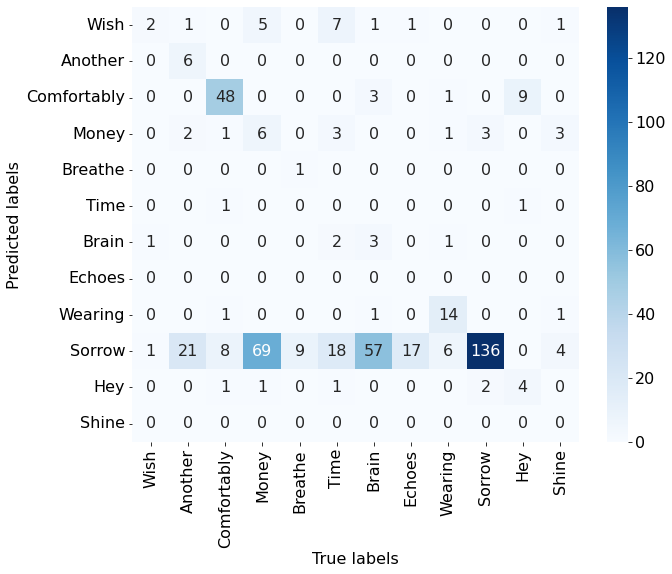

In [57]:
predict_plot_cm(CNN1D_model, x_test, test_labels)

# Transformer

In [14]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tfkl.LayerNormalization(epsilon=1e-6)(inputs)
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tfkl.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.LayerNormalization(epsilon=1e-6)(res)
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tfk.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
        x = tfkl.Dropout(mlp_dropout)(x)
    outputs = tfkl.Dense(classes, activation="softmax")(x)
    return tfk.Model(inputs, outputs)

In [17]:
transformer_model = build_transformer_model(
    input_shape,
    head_size=128,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.5,
    dropout=0.5,
)

#transformer_model.compile(
#    loss="sparse_categorical_crossentropy",
#    optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
#    metrics=["sparse_categorical_accuracy"],
#)
transformer_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.01), metrics='accuracy')
transformer_model.summary()

#callbacks = [tfk.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 layer_normalization_16 (LayerN  (None, 36, 6)       12          ['input_2[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 36, 6)       13830       ['layer_normalization_16[0][0]', 
 eadAttention)                                                    'layer_normalization_16[0][0]'] 
                                                                                            

In [18]:
history = transformer_model.fit(
    x = x_train,
    y = train_labels,
    batch_size = 128,
    epochs = epochs,
    #class_weight = class_weights_dict,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
16/16 [==============================] - 5s 64ms/step - loss: 104.8448 - accuracy: 0.1071 - val_loss: 73.7166 - val_accuracy: 0.1831 - lr: 0.0100
Epoch 2/500
16/16 [==============================] - 0s 24ms/step - loss: 70.2002 - accuracy: 0.1709 - val_loss: 69.6749 - val_accuracy: 0.0597 - lr: 0.0100
Epoch 3/500
16/16 [==============================] - 0s 26ms/step - loss: 51.1260 - accuracy: 0.1457 - val_loss: 61.3444 - val_accuracy: 0.2263 - lr: 0.0100
Epoch 4/500
16/16 [==============================] - 0s 24ms/step - loss: 59.4789 - accuracy: 0.1590 - val_loss: 58.1638 - val_accuracy: 0.1337 - lr: 0.0100
Epoch 5/500
16/16 [==============================] - 0s 27ms/step - loss: 42.7426 - accuracy: 0.1750 - val_loss: 38.4210 - val_accuracy: 0.2284 - lr: 0.0100
Epoch 6/500
16/16 [==============================] - 0s 26ms/step - loss: 19.0279 - accuracy: 0.2892 - val_loss: 19.9517 - val_accuracy: 0.3045 - lr: 0.0100
Epoch 7/500
16/16 [==============================] - 0s 2

# Augmentation

In [12]:
def jitter(x, sigma=0.03):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[2]))
    return np.multiply(x, factor[:,np.newaxis,:])


In [13]:
x_aug = scaling(jitter(x_train))
y_aug = scaling(jitter(x_test))

In [32]:
print(x_train[0][0])
print(x_aug[0][0])

[-0.438   2.4157 14.889  26.57   33.145  19.226 ]
[-0.44884769  2.51826762 13.53619564 29.44413839 35.37339593 21.50016797]


In [92]:
aug_x_train = np.concatenate((x_train, x_aug))
aug_train_labels = np.concatenate((train_labels, train_labels))
aug_x_test = np.concatenate((x_test, y_aug))
aug_test_labels = np.concatenate((test_labels, test_labels))

In [119]:
aug_bilstm_model = build_BiLSTM_classifier(input_shape, classes)
aug_bilstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_16 (Bidirecti  (None, 36, 256)          138240    
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_45 (Dense)            (None, 64)                16448     
                                                                 
 dense_46 (Dense)            (None, 12)                780   

In [120]:
# Train the model
history = aug_bilstm_model.fit(
    x = aug_x_train,
    y = aug_train_labels,
    batch_size = 128,
    epochs = epochs,
    #class_weight = class_weights_dict,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
33/33 [==============================] - 9s 107ms/step - loss: 1.7941 - accuracy: 0.4285 - val_loss: 1.3709 - val_accuracy: 0.5096 - lr: 0.0010
Epoch 2/500
33/33 [==============================] - 1s 19ms/step - loss: 1.2057 - accuracy: 0.5911 - val_loss: 1.0860 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 3/500
33/33 [==============================] - 1s 17ms/step - loss: 0.9613 - accuracy: 0.6790 - val_loss: 1.0376 - val_accuracy: 0.6192 - lr: 0.0010
Epoch 4/500
33/33 [==============================] - 1s 16ms/step - loss: 0.7752 - accuracy: 0.7430 - val_loss: 1.0639 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 5/500
33/33 [==============================] - 1s 17ms/step - loss: 0.6369 - accuracy: 0.7900 - val_loss: 1.0298 - val_accuracy: 0.6658 - lr: 0.0010
Epoch 6/500
33/33 [==============================] - 1s 18ms/step - loss: 0.5092 - accuracy: 0.8331 - val_loss: 1.1696 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 7/500
33/33 [==============================] - 1s 18ms/step - l

12/12 [==============================] - 1s 7ms/step
Accuracy: 0.6904
Precision: 0.608
Recall: 0.6057
F1: 0.5873


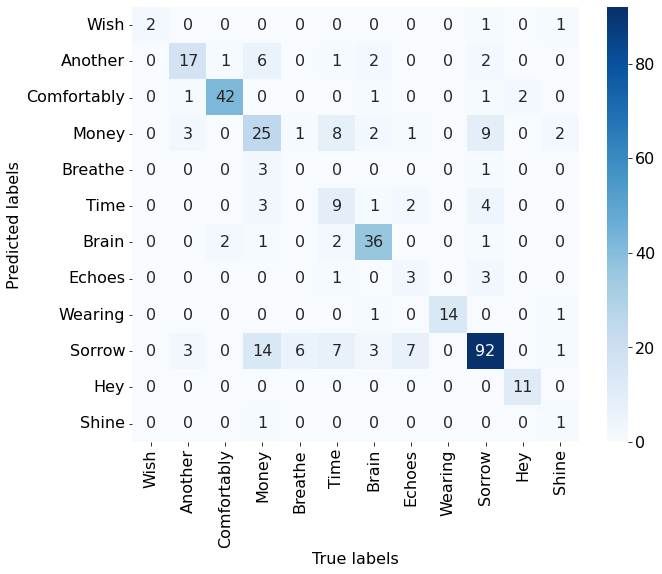

In [117]:
predict_plot_cm(aug_bilstm_model, x_test, test_labels)

In [118]:
aug_bilstm_model.save('challenge2/Aug_BiLSTM_16_L2')

In [136]:
def cnn_resnet(input_shape, classes):
  input_layer = tfkl.Input(shape=input_shape, name='Input')

  conv1 = tfkl.Conv1D(filters=16, kernel_size=3, kernel_initializer='he_uniform',
                      kernel_regularizer=tfk.regularizers.l2(0.0001),
                      strides=1, padding='same')(input_layer)        
  bn1 = tfkl.BatchNormalization()(conv1)
  act1 = tfkl.Activation('relu')(bn1)
  block1 = tfkl.Dropout(rate=0.2)(act1)

  conv2 = tfkl.Conv1D(filters=32, kernel_size=3, kernel_initializer='he_uniform',
                      #kernel_regularizer=tfk.regularizers.l2(0.0001),
                      strides=1, padding='same')(block1)
  bn2 = tfkl.BatchNormalization()(conv2)
  act2 = tfkl.Activation('relu')(bn2)
  #block2 = tfkl.Dropout(rate=0.2)(act2)

  conv3 = tfkl.Conv1D(filters=64, kernel_size=3, kernel_initializer='he_uniform',
                      #kernel_regularizer=tfk.regularizers.l2(0.0001),
                      strides=1, padding='same')(act2)
  bn3 = tfkl.BatchNormalization()(conv3)
  act3 = tfkl.Activation('relu')(bn3)
  #block3 = tfkl.Dropout(rate=0.2)(act3)

  conv4 = tfkl.Conv1D(filters=128, kernel_size=3, kernel_initializer='he_uniform',
                      #kernel_regularizer=tfk.regularizers.l2(0.0001),
                      strides=1, padding='same')(act3)
  bn4 = tfkl.BatchNormalization()(conv4)
  act4 = tfkl.Activation('relu')(bn4)
  #block4 = tfkl.Dropout(rate=0.2)(act4)

  flat = tfkl.GlobalAveragePooling1D()(act4)

  #dropout = tfkl.Dropout(0.3, seed=seed)(flat)
  classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(flat)
  #dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
  output_layer = tfkl.Dense(units=classes, activation='softmax', kernel_initializer=tfk.initializers.HeUniform(seed), name='output_layer')(classifier_layer)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

  return model

In [137]:
cnn_resnet_model = cnn_resnet(input_shape, classes)
cnn_resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_57 (Conv1D)          (None, 36, 16)            304       
                                                                 
 batch_normalization_51 (Bat  (None, 36, 16)           64        
 chNormalization)                                                
                                                                 
 activation_51 (Activation)  (None, 36, 16)            0         
                                                                 
 dropout_29 (Dropout)        (None, 36, 16)            0         
                                                                 
 conv1d_58 (Conv1D)          (None, 36, 32)            1568      
                                                             

In [138]:
# Train the model
history = cnn_resnet_model.fit(
    x = aug_x_train,
    y = aug_train_labels,
    batch_size = batch_size,
    epochs = epochs,
    #class_weight = class_weights_dict,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
33/33 [==============================] - 2s 16ms/step - loss: 2.0652 - accuracy: 0.3391 - val_loss: 2.1487 - val_accuracy: 0.3753 - lr: 0.0010
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 1.7783 - accuracy: 0.4121 - val_loss: 1.8749 - val_accuracy: 0.3836 - lr: 0.0010
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 1.6120 - accuracy: 0.4554 - val_loss: 1.7356 - val_accuracy: 0.3890 - lr: 0.0010
Epoch 4/500
33/33 [==============================] - 0s 8ms/step - loss: 1.4786 - accuracy: 0.4898 - val_loss: 1.6289 - val_accuracy: 0.4301 - lr: 0.0010
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 1.4061 - accuracy: 0.5051 - val_loss: 1.6859 - val_accuracy: 0.4137 - lr: 0.0010
Epoch 6/500
33/33 [==============================] - 0s 8ms/step - loss: 1.3801 - accuracy: 0.5223 - val_loss: 1.5675 - val_accuracy: 0.4274 - lr: 0.0010
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 1.

12/12 [==============================] - 0s 8ms/step
Accuracy: 0.6329
Precision: 0.5774
Recall: 0.5057
F1: 0.507


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


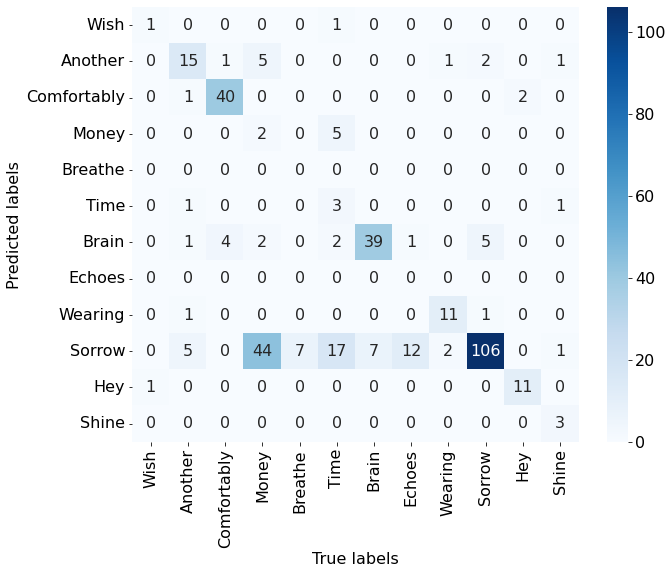

In [139]:
predict_plot_cm(cnn_resnet_model, x_test, test_labels)

# SMOTE

## Oversampling

In [14]:
# Reshape train data
reshaped_x_train, reshaped_train_labels = reshape_array(x_train, train_labels)

Input Data Shape: (2064, 36, 6)
Input Labels Shape: (2064, 12)
Reshaped Data: (74304, 6)
Reshaped Labels: (74304, 12)


{0: 1080, 1: 3636, 2: 8316, 3: 11592, 4: 1908, 5: 4680, 6: 9612, 7: 2232, 8: 3672, 9: 23472, 10: 2340, 11: 1764}


([<matplotlib.axis.XTick at 0x7fac5e0b1f40>,
 <a list of 12 Text major ticklabel objects>)

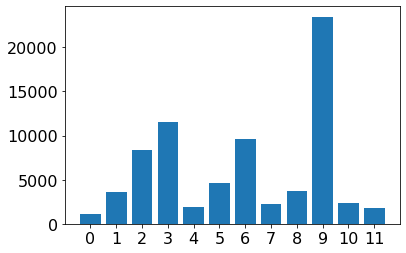

In [15]:
data, counts_data = np.unique(np.argmax(reshaped_train_labels, axis=1), return_counts=True)
class_freq = dict(zip(data, counts_data))
print(class_freq)
plt.bar(list(class_freq.keys()),list(class_freq.values()))
plt.xticks(np.arange(12))

In [16]:
smote = SMOTE(random_state=seed)
os_x_train, os_train_labels = smote.fit_resample(reshaped_x_train, reshaped_train_labels)
print('Oversampled Train Data:', os_x_train.shape)
print('Oversampled Train Target:', os_train_labels.shape)

Oversampled Train Data: (281664, 6)
Oversampled Train Target: (281664, 12)


{0: 23472, 1: 23472, 2: 23472, 3: 23472, 4: 23472, 5: 23472, 6: 23472, 7: 23472, 8: 23472, 9: 23472, 10: 23472, 11: 23472}


([<matplotlib.axis.XTick at 0x7fac5db54ca0>,
 <a list of 12 Text major ticklabel objects>)

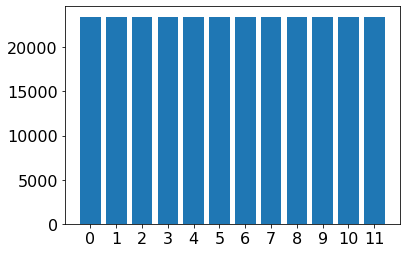

In [17]:
data, counts_data = np.unique(np.argmax(os_train_labels, axis=1), return_counts=True)
class_freq = dict(zip(data, counts_data))
print(class_freq)
plt.bar(list(class_freq.keys()),list(class_freq.values()))
plt.xticks(np.arange(12))

In [18]:
# Restore shape
os_train, os_labels = restore_array_shape(os_x_train, os_train_labels)

Input Data Shape: (281664, 6)
Input Labels Shape: (281664, 12)
Restored Data: (7824, 36, 6)
Restored Labels: (7824, 12)


{0: 652, 1: 652, 2: 652, 3: 652, 4: 652, 5: 652, 6: 652, 7: 652, 8: 652, 9: 652, 10: 652, 11: 652}


([<matplotlib.axis.XTick at 0x7fac5db462e0>,
 <a list of 12 Text major ticklabel objects>)

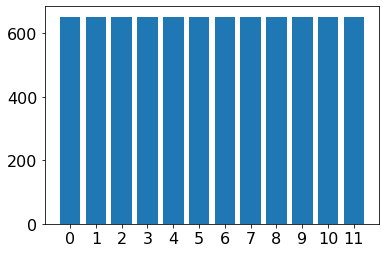

In [19]:
data, counts_data = np.unique(np.argmax(os_labels, axis=1), return_counts=True)
class_freq = dict(zip(data, counts_data))
print(class_freq)
plt.bar(list(class_freq.keys()),list(class_freq.values()))
plt.xticks(np.arange(12))

### LSTM Model

In [20]:
os_lstm_model = build_LSTM_classifier(input_shape, classes)
os_lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 36, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 12)                780   

In [21]:
# Train the model
history = os_lstm_model.fit(
    x = os_train,
    y = os_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/500
62/62 [==============================] - 9s 22ms/step - loss: 1.5053 - accuracy: 0.4788 - val_loss: 1.8055 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 2/500
62/62 [==============================] - 1s 9ms/step - loss: 0.7383 - accuracy: 0.7643 - val_loss: 1.3078 - val_accuracy: 0.5534 - lr: 0.0010
Epoch 3/500
62/62 [==============================] - 1s 9ms/step - loss: 0.5805 - accuracy: 0.8202 - val_loss: 1.2076 - val_accuracy: 0.6027 - lr: 0.0010
Epoch 4/500
62/62 [==============================] - 1s 9ms/step - loss: 0.4829 - accuracy: 0.8562 - val_loss: 1.3080 - val_accuracy: 0.5863 - lr: 0.0010
Epoch 5/500
62/62 [==============================] - 1s 9ms/step - loss: 0.4427 - accuracy: 0.8653 - val_loss: 1.2356 - val_accuracy: 0.6192 - lr: 0.0010
Epoch 6/500
62/62 [==============================] - 1s 9ms/step - loss: 0.4143 - accuracy: 0.8737 - val_loss: 1.2687 - val_accuracy: 0.6219 - lr: 0.0010
Epoch 7/500
62/62 [==============================] - 1s 9ms/step - loss: 0.

12/12 [==============================] - 1s 4ms/step
Accuracy: 0.6877
Precision: 0.5528
Recall: 0.5639
F1: 0.5448


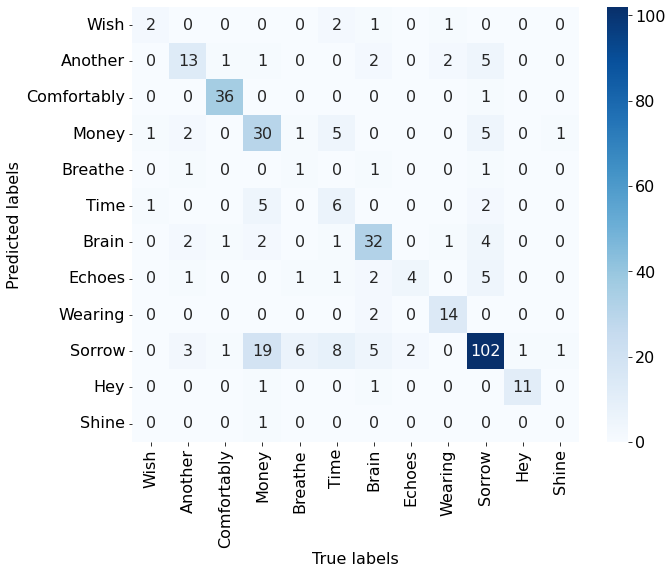

In [22]:
predict_plot_cm(os_lstm_model, x_test, test_labels)

### BiLSTM Model

In [26]:
os_bilstm_model = build_BiLSTM_classifier(input_shape, classes)
os_bilstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 12)                780   

In [27]:
# Train the model
history = os_bilstm_model.fit(
    x = os_train,
    y = os_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.25, min_lr=1e-6)
    ]
).history

Epoch 1/500
62/62 [==============================] - 7s 37ms/step - loss: 1.1868 - accuracy: 0.6025 - val_loss: 1.4121 - val_accuracy: 0.5233 - lr: 0.0010
Epoch 2/500
62/62 [==============================] - 1s 15ms/step - loss: 0.5489 - accuracy: 0.8142 - val_loss: 1.1778 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/500
62/62 [==============================] - 1s 15ms/step - loss: 0.4326 - accuracy: 0.8538 - val_loss: 1.1811 - val_accuracy: 0.5753 - lr: 0.0010
Epoch 4/500
62/62 [==============================] - 1s 15ms/step - loss: 0.3815 - accuracy: 0.8751 - val_loss: 1.0779 - val_accuracy: 0.6329 - lr: 0.0010
Epoch 5/500
62/62 [==============================] - 1s 15ms/step - loss: 0.3169 - accuracy: 0.8970 - val_loss: 1.1011 - val_accuracy: 0.6247 - lr: 0.0010
Epoch 6/500
62/62 [==============================] - 1s 15ms/step - loss: 0.2801 - accuracy: 0.9078 - val_loss: 1.2069 - val_accuracy: 0.6164 - lr: 0.0010
Epoch 7/500
62/62 [==============================] - 1s 15ms/step - lo

12/12 [==============================] - 1s 6ms/step
Accuracy: 0.6959
Precision: 0.6355
Recall: 0.6321
F1: 0.6249


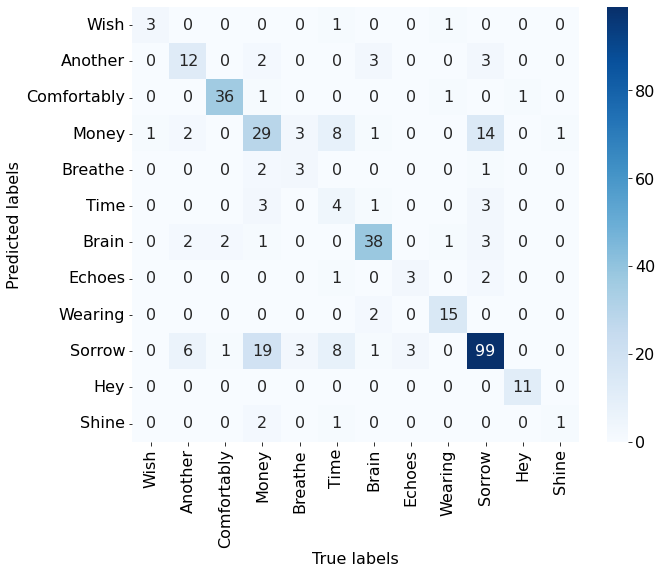

In [28]:
predict_plot_cm(os_bilstm_model, x_test, test_labels)

In [53]:
os_bilstm_model.save('challenge2/OS_BiLSTM_128_L2_V2.h5')

## Oversample and Scale



In [64]:
# Reshape train data
dims_train = x_train.shape
dims_target = train_labels.shape
reshaped_x_train = np.zeros((dims_train[0] * dims_train[1], dims_train[2]))
reshaped_train_labels = np.zeros((dims_target[0] * dims_train[1], dims_target[1]))
element = 0
for sample in range(dims_train[0]):
    for timestep in range(dims_train[1]):
        reshaped_x_train[element] = x_train[sample, timestep, :]
        reshaped_train_labels[element] = train_labels[sample, :]
        element += 1
print(reshaped_x_train.shape)
print(reshaped_train_labels.shape)

(69948, 6)
(69948, 12)


In [65]:
# Reshape test data
dims_test = x_test.shape
dims_target = test_labels.shape
reshaped_x_test = np.zeros((dims_test[0] * dims_test[1], dims_test[2]))
reshaped_test_labels = np.zeros((dims_target[0] * dims_test[1], dims_target[1]))
element = 0
for sample in range(dims_test[0]):
    for timestep in range(dims_test[1]):
        reshaped_x_test[element] = x_test[sample, timestep, :]
        reshaped_test_labels[element] = test_labels[sample, :]
        element += 1
print(reshaped_x_test.shape)
print(reshaped_test_labels.shape)

(17496, 6)
(17496, 12)


In [68]:
smote = SMOTE(random_state=seed)
os_x_train, os_train_labels = smote.fit_resample(reshaped_x_train, reshaped_train_labels)
print('Oversampled Train Data:', os_x_train.shape)
print('Oversampled Train Target:', os_train_labels.shape)

Oversampled Train Data: (274752, 6)
Oversampled Train Target: (274752, 12)


In [69]:
standard_scaler = StandardScaler()
ss_train = standard_scaler.fit_transform(os_x_train)
ss_test = standard_scaler.transform(reshaped_x_test)

In [70]:
# Restore train shape
train_restored_shape = (ss_train.shape[0]//dims_train[1], dims_train[1], dims_train[2])
target_restored_shape = (ss_train.shape[0]//dims_train[1], dims_target[1])
os_train = np.zeros(train_restored_shape)
os_labels = np.zeros(target_restored_shape)
element = 0
for sample in range(train_restored_shape[0]):
  for timestep in range(dims_train[1]):
    os_train[sample, timestep, :] = ss_train[element]
    os_labels[sample, :] = os_train_labels[element]
    element += 1
print(os_train.shape)
print(os_labels.shape)

(7632, 36, 6)
(7632, 12)


In [71]:
# Restore test shape
test_restored_shape = (ss_test.shape[0]//dims_train[1], dims_test[1], dims_test[2])
target_restored_shape = (ss_test.shape[0]//dims_train[1], dims_target[1])
restored_test = np.zeros(test_restored_shape)
restored_test_labels = np.zeros(target_restored_shape)
element = 0
for sample in range(test_restored_shape[0]):
  for timestep in range(dims_train[1]):
    restored_test[sample, timestep, :] = ss_test[element]
    restored_test_labels[sample, :] = reshaped_test_labels[element]
    element += 1
print(restored_test.shape)
print(restored_test_labels.shape)

(486, 36, 6)
(486, 12)


### BiLSTM Model

In [72]:
os_scaled_bilstm_model = build_BiLSTM_classifier(input_shape, classes)
os_scaled_bilstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 36, 256)          138240    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 64)                16448     
                                                                 
 dense_32 (Dense)            (None, 12)                780   

In [73]:
# Train the model
history = os_scaled_bilstm_model.fit(
    x = os_train,
    y = os_labels,
    batch_size = 128,
    epochs = epochs,
    validation_data=(restored_test, restored_test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/500
60/60 [==============================] - 8s 40ms/step - loss: 1.9134 - accuracy: 0.3341 - val_loss: 2.1469 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 2/500
60/60 [==============================] - 1s 17ms/step - loss: 1.4150 - accuracy: 0.4824 - val_loss: 2.0054 - val_accuracy: 0.2778 - lr: 0.0010
Epoch 3/500
60/60 [==============================] - 1s 17ms/step - loss: 1.2712 - accuracy: 0.5445 - val_loss: 1.9696 - val_accuracy: 0.2819 - lr: 0.0010
Epoch 4/500
60/60 [==============================] - 1s 17ms/step - loss: 1.2260 - accuracy: 0.5548 - val_loss: 1.8509 - val_accuracy: 0.3354 - lr: 0.0010
Epoch 5/500
60/60 [==============================] - 1s 17ms/step - loss: 1.1560 - accuracy: 0.5850 - val_loss: 1.9663 - val_accuracy: 0.2675 - lr: 0.0010
Epoch 6/500
60/60 [==============================] - 1s 17ms/step - loss: 1.1075 - accuracy: 0.6064 - val_loss: 2.0200 - val_accuracy: 0.2202 - lr: 0.0010
Epoch 7/500
60/60 [==============================] - 1s 17ms/step - lo

16/16 [==============================] - 1s 6ms/step
Accuracy: 0.5679
Precision: 0.4954
Recall: 0.4611
F1: 0.4696


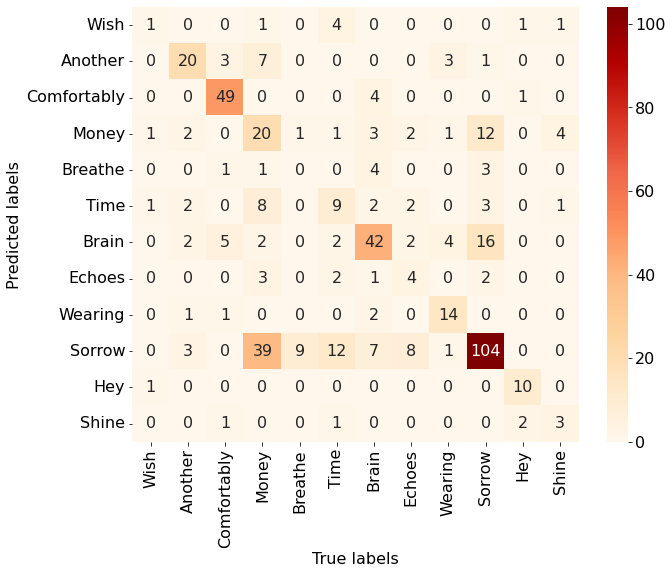

In [74]:
predict_plot_cm(os_scaled_bilstm_model, restored_test, restored_test_labels)

## Augment and Oversample

In [49]:
x_aug = scaling(jitter(x_train))
aug_x_train = np.concatenate((x_train, x_aug))
aug_train_labels = np.concatenate((train_labels, train_labels))

In [50]:
reshaped_x_train, reshaped_train_labels = reshape_array(aug_x_train, aug_train_labels)
smote = SMOTE(random_state=seed)
os_x_train, os_train_labels = smote.fit_resample(reshaped_x_train, reshaped_train_labels)
print('Oversampled Train Data:', os_x_train.shape)
print('Oversampled Train Target:', os_train_labels.shape)

Input Data Shape: (4128, 36, 6)
Input Labels Shape: (4128, 12)
Reshaped Data: (148608, 6)
Reshaped Labels: (148608, 12)
Oversampled Train Data: (570240, 6)
Oversampled Train Target: (570240, 12)


{0: 47520, 1: 47520, 2: 47520, 3: 47520, 4: 47520, 5: 47520, 6: 47520, 7: 47520, 8: 47520, 9: 47520, 10: 47520, 11: 47520}


([<matplotlib.axis.XTick at 0x7f79b4ac95e0>,
 <a list of 12 Text major ticklabel objects>)

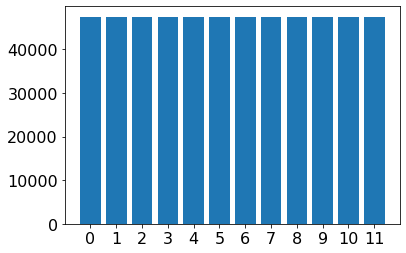

In [51]:
data, counts_data = np.unique(np.argmax(os_train_labels, axis=1), return_counts=True)
class_freq = dict(zip(data, counts_data))
print(class_freq)
plt.bar(list(class_freq.keys()),list(class_freq.values()))
plt.xticks(np.arange(12))

In [52]:
aug_os_train, aug_os_labels = restore_array_shape(os_x_train, os_train_labels)

Input Data Shape: (570240, 6)
Input Labels Shape: (570240, 12)
Restored Data: (15840, 36, 6)
Restored Labels: (15840, 12)


### LSTM Model

In [42]:
aug_os_lstm_model = build_LSTM_classifier(input_shape, classes)
aug_os_lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_8 (LSTM)               (None, 36, 128)           69120     
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 12)                780   

In [43]:
# Train the model
history = aug_os_lstm_model.fit(
    x = aug_os_train,
    y = aug_os_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.25, min_lr=1e-6)
    ]
).history

Epoch 1/500
123/123 [==============================] - 4s 15ms/step - loss: 1.1717 - accuracy: 0.6107 - val_loss: 1.4238 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 2/500
123/123 [==============================] - 1s 9ms/step - loss: 0.5904 - accuracy: 0.8137 - val_loss: 1.2392 - val_accuracy: 0.6027 - lr: 0.0010
Epoch 3/500
123/123 [==============================] - 1s 8ms/step - loss: 0.4862 - accuracy: 0.8512 - val_loss: 1.2596 - val_accuracy: 0.5699 - lr: 0.0010
Epoch 4/500
123/123 [==============================] - 1s 9ms/step - loss: 0.4154 - accuracy: 0.8712 - val_loss: 1.2623 - val_accuracy: 0.5918 - lr: 0.0010
Epoch 5/500
123/123 [==============================] - 1s 9ms/step - loss: 0.3770 - accuracy: 0.8862 - val_loss: 1.1207 - val_accuracy: 0.6548 - lr: 0.0010
Epoch 6/500
123/123 [==============================] - 1s 9ms/step - loss: 0.3193 - accuracy: 0.9055 - val_loss: 1.2394 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 7/500
123/123 [==============================] - 1s 9ms/s

12/12 [==============================] - 1s 4ms/step
Accuracy: 0.6849
Precision: 0.5737
Recall: 0.5723
F1: 0.5587


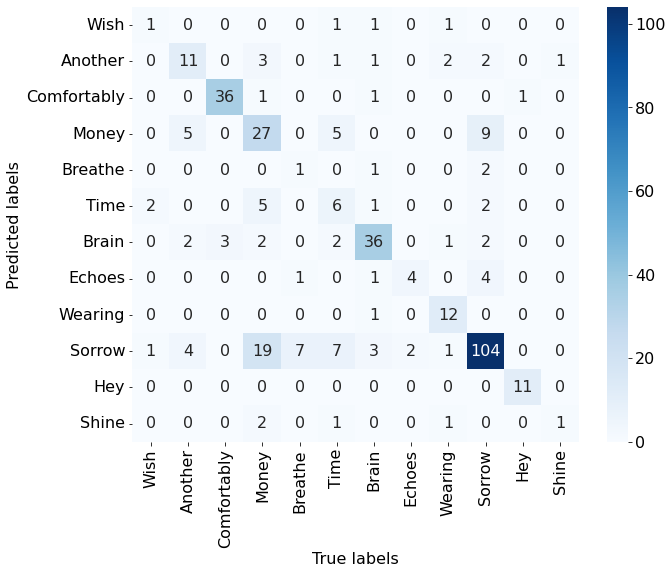

In [44]:
predict_plot_cm(aug_os_lstm_model, x_test, test_labels)

### BiLSTM Model

In [48]:
aug_os_bilstm_model = build_BiLSTM_classifier(input_shape, classes)
aug_os_bilstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                16448     
                                                                 
 dense_20 (Dense)            (None, 12)                780   

In [49]:
# Train the model
history = aug_os_bilstm_model.fit(
    x = aug_os_train,
    y = aug_os_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.25, min_lr=1e-6)
    ]
).history

Epoch 1/500
123/123 [==============================] - 9s 31ms/step - loss: 0.9020 - accuracy: 0.6932 - val_loss: 1.2252 - val_accuracy: 0.6027 - lr: 0.0010
Epoch 2/500
123/123 [==============================] - 2s 15ms/step - loss: 0.4336 - accuracy: 0.8530 - val_loss: 1.0891 - val_accuracy: 0.6384 - lr: 0.0010
Epoch 3/500
123/123 [==============================] - 2s 15ms/step - loss: 0.3331 - accuracy: 0.8903 - val_loss: 1.1911 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 4/500
123/123 [==============================] - 2s 15ms/step - loss: 0.2730 - accuracy: 0.9127 - val_loss: 1.1457 - val_accuracy: 0.6521 - lr: 0.0010
Epoch 5/500
123/123 [==============================] - 2s 15ms/step - loss: 0.2248 - accuracy: 0.9282 - val_loss: 1.2004 - val_accuracy: 0.6384 - lr: 0.0010
Epoch 6/500
123/123 [==============================] - 2s 15ms/step - loss: 0.1847 - accuracy: 0.9408 - val_loss: 1.1744 - val_accuracy: 0.6658 - lr: 0.0010
Epoch 7/500
123/123 [==============================] - 2s 

12/12 [==============================] - 1s 7ms/step
Accuracy: 0.7041
Precision: 0.6298
Recall: 0.6633
F1: 0.6387


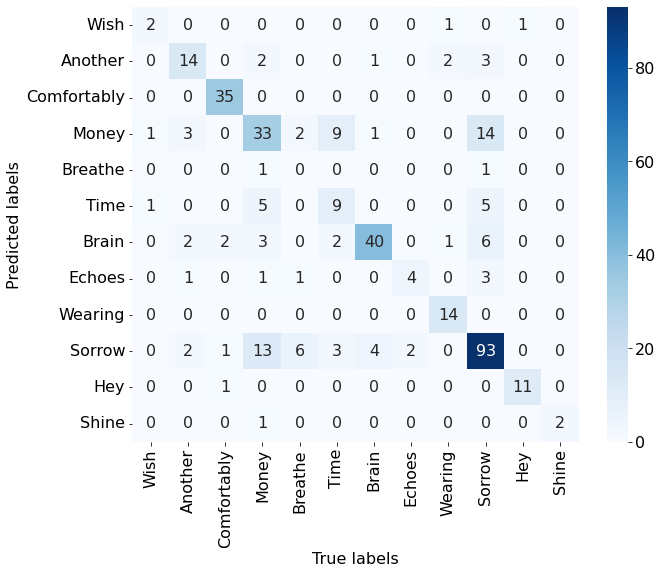

In [50]:
predict_plot_cm(aug_os_bilstm_model, x_test, test_labels)

In [52]:
aug_os_bilstm_model.save('challenge2/Aug_OS_BiLSTM_128_L2.h5')

### CNN Resnet

In [93]:
def cnn_resnet(input_shape, classes):
    # I. Fawaz, G. Forestier, J. Weber, L. Idoumghar, P-A Muller, "Data augmentation using synthetic data for time series classification with deep residual networks," International Workshop on Advanced Analytics and Learning on Temporal Data ECML/PKDD, 2018

    ip = tfkl.Input(shape=input_shape)
    residual = ip
    conv = ip

    for i, nb_nodes in enumerate([64, 128, 128]):
        conv = tfkl.Conv1D(nb_nodes, 8, padding='same', kernel_initializer="glorot_uniform")(conv)
        conv = tfkl.BatchNormalization()(conv)
        conv = tfkl.Activation('relu')(conv)

        conv = tfkl.Conv1D(nb_nodes, 5, padding='same', kernel_initializer="glorot_uniform")(conv)
        conv = tfkl.BatchNormalization()(conv)
        conv = tfkl.Activation('relu')(conv)

        conv = tfkl.Conv1D(nb_nodes, 3, padding='same', kernel_initializer="glorot_uniform")(conv)
        conv = tfkl.BatchNormalization()(conv)
        conv = tfkl.Activation('relu')(conv)

        if i < 2:
            # expands dimensions according to Fawaz et al.
            residual = tfkl.Conv1D(nb_nodes, 1, padding='same', kernel_initializer="glorot_uniform")(residual)
        residual = tfkl.BatchNormalization()(residual)
        conv = tfkl.add([residual, conv])
        conv = tfkl.Activation('relu')(conv)

        residual = conv

    flat = tfkl.GlobalAveragePooling1D()(conv)

    out = tfkl.Dense(classes, activation='softmax')(flat)

    model = tfk.Model([ip], [out])

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model

In [94]:
aug_os_cnn_model = cnn_resnet(input_shape, classes)
aug_os_cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 36, 64)       3136        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 36, 64)      256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 36, 64)       0           ['batch_normalization[0][0]']

In [95]:
# Train the model
history = aug_os_cnn_model.fit(
    x = aug_os_train,
    y = aug_os_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.25, min_lr=1e-6)
    ]
).history

Epoch 1/500
123/123 [==============================] - 11s 26ms/step - loss: 1.1182 - accuracy: 0.6065 - val_loss: 1.3729 - val_accuracy: 0.5178 - lr: 0.0010
Epoch 2/500
123/123 [==============================] - 2s 17ms/step - loss: 0.7283 - accuracy: 0.7427 - val_loss: 1.8839 - val_accuracy: 0.4904 - lr: 0.0010
Epoch 3/500
123/123 [==============================] - 2s 17ms/step - loss: 0.6469 - accuracy: 0.7697 - val_loss: 3.4818 - val_accuracy: 0.2493 - lr: 0.0010
Epoch 4/500
123/123 [==============================] - 2s 20ms/step - loss: 0.5861 - accuracy: 0.7941 - val_loss: 2.5256 - val_accuracy: 0.5397 - lr: 0.0010
Epoch 5/500
123/123 [==============================] - 3s 21ms/step - loss: 0.5487 - accuracy: 0.8064 - val_loss: 1.1557 - val_accuracy: 0.5973 - lr: 0.0010
Epoch 6/500
123/123 [==============================] - 2s 17ms/step - loss: 0.5228 - accuracy: 0.8161 - val_loss: 1.2449 - val_accuracy: 0.5479 - lr: 0.0010
Epoch 7/500
123/123 [==============================] - 2s

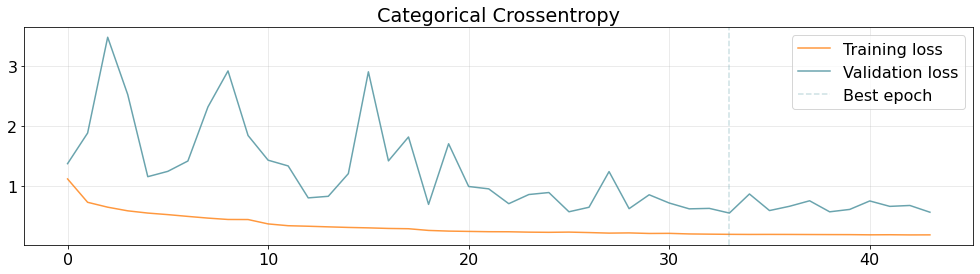

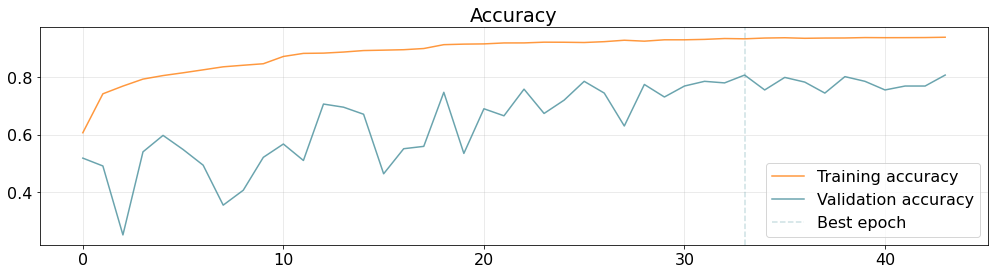

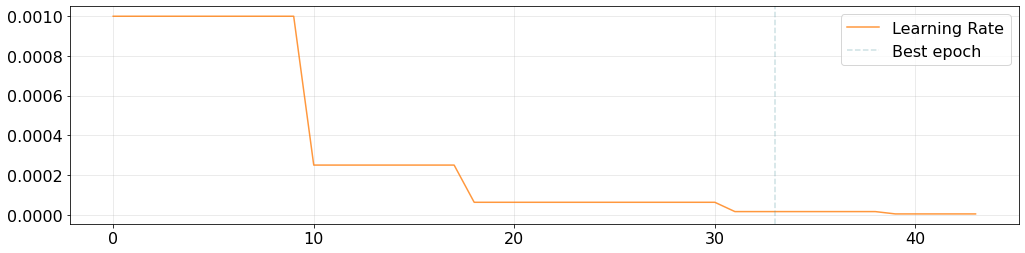

In [96]:
plot_training_history(history)

12/12 [==============================] - 1s 22ms/step
Accuracy: 0.8082
Precision: 0.847
Recall: 0.7185
F1: 0.7616


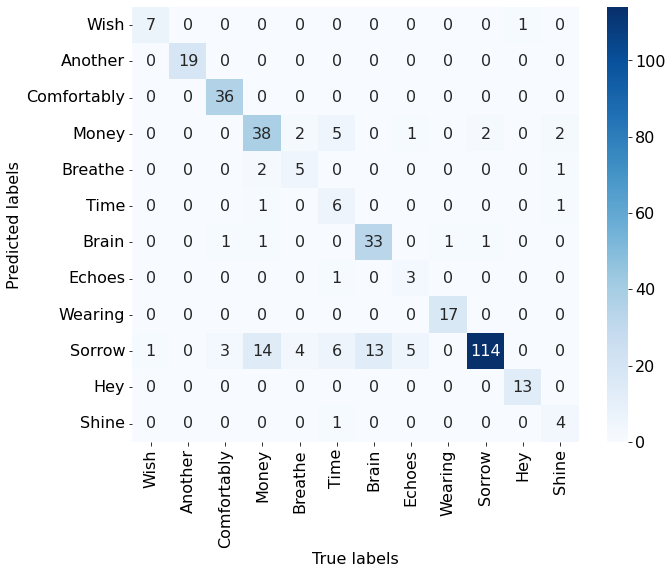

In [97]:
predict_plot_cm(aug_os_cnn_model, x_test, test_labels)

In [99]:
aug_os_cnn_model.save('challenge2/Aug_OS_CNN_128.h5')

### CNN with L2

In [100]:
def cnn_resnet_l2(input_shape, classes):
    # I. Fawaz, G. Forestier, J. Weber, L. Idoumghar, P-A Muller, "Data augmentation using synthetic data for time series classification with deep residual networks," International Workshop on Advanced Analytics and Learning on Temporal Data ECML/PKDD, 2018

    ip = tfkl.Input(shape=input_shape)
    residual = ip
    conv = ip

    for i, nb_nodes in enumerate([64, 128, 128]):
        conv = tfkl.Conv1D(nb_nodes, 8, padding='same', kernel_initializer="glorot_uniform")(conv)
        conv = tfkl.BatchNormalization()(conv)
        conv = tfkl.Activation('relu')(conv)

        conv = tfkl.Conv1D(nb_nodes, 5, padding='same', kernel_initializer="glorot_uniform")(conv)
        conv = tfkl.BatchNormalization()(conv)
        conv = tfkl.Activation('relu')(conv)

        conv = tfkl.Conv1D(nb_nodes, 3, padding='same', kernel_initializer="glorot_uniform")(conv)
        conv = tfkl.BatchNormalization()(conv)
        conv = tfkl.Activation('relu')(conv)

        if i < 2:
            # expands dimensions according to Fawaz et al.
            residual = tfkl.Conv1D(nb_nodes, 1, padding='same', kernel_initializer="glorot_uniform")(residual)
        residual = tfkl.BatchNormalization()(residual)
        conv = tfkl.add([residual, conv])
        conv = tfkl.Activation('relu')(conv)

        residual = conv

    flat = tfkl.GlobalAveragePooling1D()(conv)

    out = tfkl.Dense(classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(flat)

    model = tfk.Model([ip], [out])

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model

In [101]:
aug_os_cnn_l2_model = cnn_resnet_l2(input_shape, classes)
aug_os_cnn_l2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 36, 64)       3136        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 36, 64)      256         ['conv1d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_12 (Activation)     (None, 36, 64)       0           ['batch_normalization_12[0]

In [102]:
# Train the model
history = aug_os_cnn_l2_model.fit(
    x = aug_os_train,
    y = aug_os_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.25, min_lr=1e-6)
    ]
).history

Epoch 1/500
123/123 [==============================] - 5s 21ms/step - loss: 1.1203 - accuracy: 0.6096 - val_loss: 1.6184 - val_accuracy: 0.3890 - lr: 0.0010
Epoch 2/500
123/123 [==============================] - 2s 18ms/step - loss: 0.7359 - accuracy: 0.7440 - val_loss: 1.3082 - val_accuracy: 0.5233 - lr: 0.0010
Epoch 3/500
123/123 [==============================] - 2s 17ms/step - loss: 0.6469 - accuracy: 0.7732 - val_loss: 1.7438 - val_accuracy: 0.5452 - lr: 0.0010
Epoch 4/500
123/123 [==============================] - 2s 20ms/step - loss: 0.5867 - accuracy: 0.7981 - val_loss: 1.3608 - val_accuracy: 0.5890 - lr: 0.0010
Epoch 5/500
123/123 [==============================] - 2s 18ms/step - loss: 0.5343 - accuracy: 0.8117 - val_loss: 2.1324 - val_accuracy: 0.3836 - lr: 0.0010
Epoch 6/500
123/123 [==============================] - 2s 17ms/step - loss: 0.5126 - accuracy: 0.8212 - val_loss: 1.5126 - val_accuracy: 0.5233 - lr: 0.0010
Epoch 7/500
123/123 [==============================] - 2s 

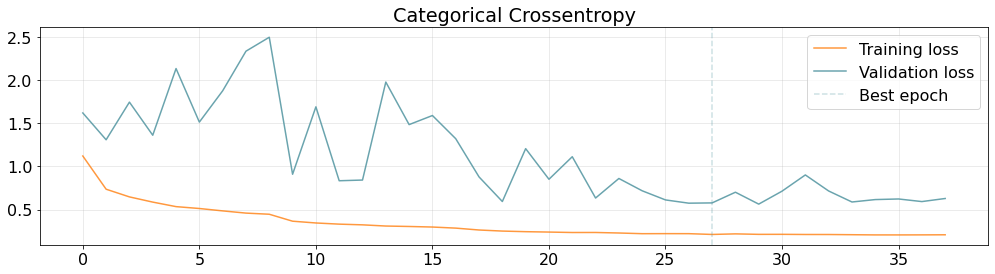

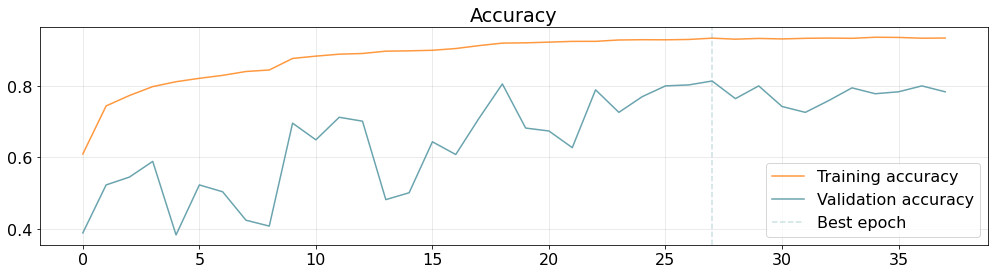

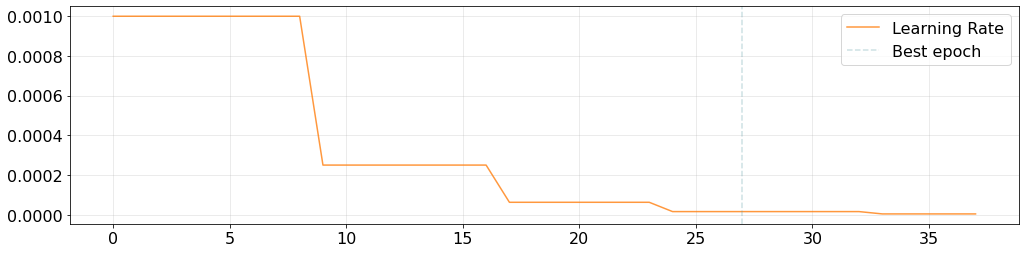

In [103]:
plot_training_history(history)

12/12 [==============================] - 0s 4ms/step
Accuracy: 0.8137
Precision: 0.8215
Recall: 0.7473
F1: 0.7747


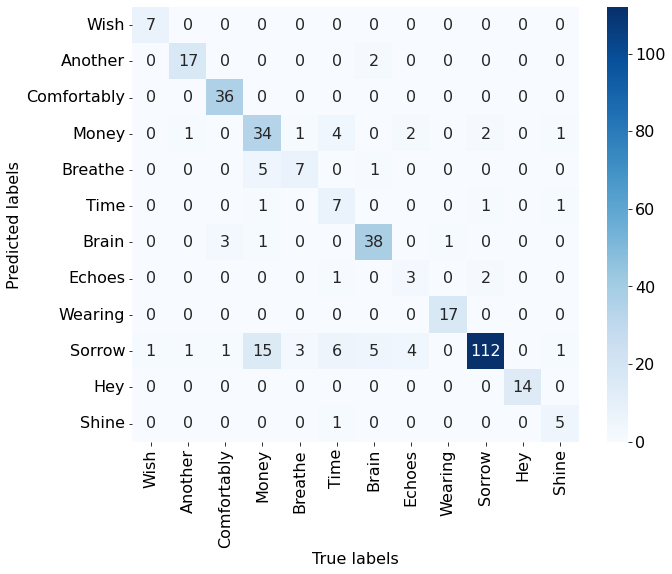

In [104]:
predict_plot_cm(aug_os_cnn_l2_model, x_test, test_labels)

In [106]:
aug_os_cnn_l2_model.save('challenge2/Aug_OS_CNN_128_L2.h5')

### CNN with L2 and Increased Patience

In [107]:
aug_os_cnn_l2_patience_model = cnn_resnet_l2(input_shape, classes)
aug_os_cnn_l2_patience_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 36, 64)       3136        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_24 (BatchN  (None, 36, 64)      256         ['conv1d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 36, 64)       0           ['batch_normalization_24[0]

In [108]:
# Train the model
history = aug_os_cnn_l2_patience_model.fit(
    x = aug_os_train,
    y = aug_os_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.25, min_lr=1e-6)
    ]
).history

Epoch 1/500
123/123 [==============================] - 5s 21ms/step - loss: 1.1347 - accuracy: 0.6017 - val_loss: 1.3704 - val_accuracy: 0.5233 - lr: 0.0010
Epoch 2/500
123/123 [==============================] - 2s 17ms/step - loss: 0.7311 - accuracy: 0.7412 - val_loss: 3.7663 - val_accuracy: 0.1753 - lr: 0.0010
Epoch 3/500
123/123 [==============================] - 2s 17ms/step - loss: 0.6458 - accuracy: 0.7712 - val_loss: 5.2305 - val_accuracy: 0.1918 - lr: 0.0010
Epoch 4/500
123/123 [==============================] - 2s 17ms/step - loss: 0.5859 - accuracy: 0.7988 - val_loss: 1.9757 - val_accuracy: 0.4712 - lr: 0.0010
Epoch 5/500
123/123 [==============================] - 2s 17ms/step - loss: 0.5490 - accuracy: 0.8104 - val_loss: 1.2112 - val_accuracy: 0.5342 - lr: 0.0010
Epoch 6/500
123/123 [==============================] - 2s 17ms/step - loss: 0.5258 - accuracy: 0.8170 - val_loss: 4.0470 - val_accuracy: 0.2247 - lr: 0.0010
Epoch 7/500
123/123 [==============================] - 2s 

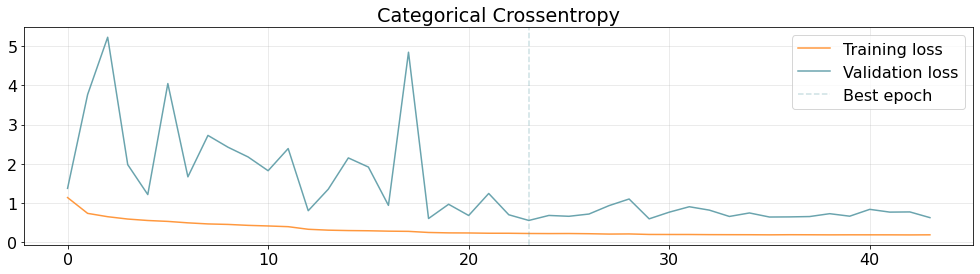

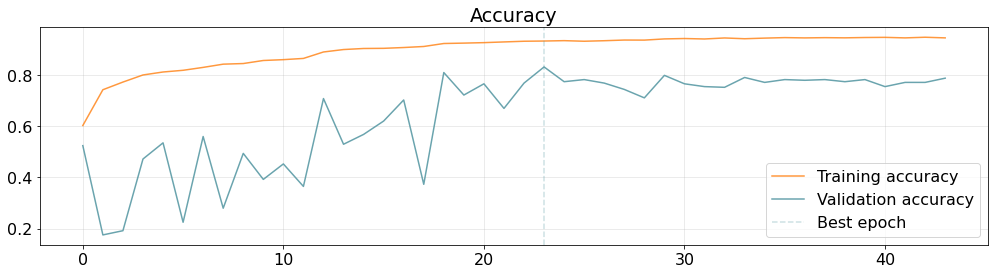

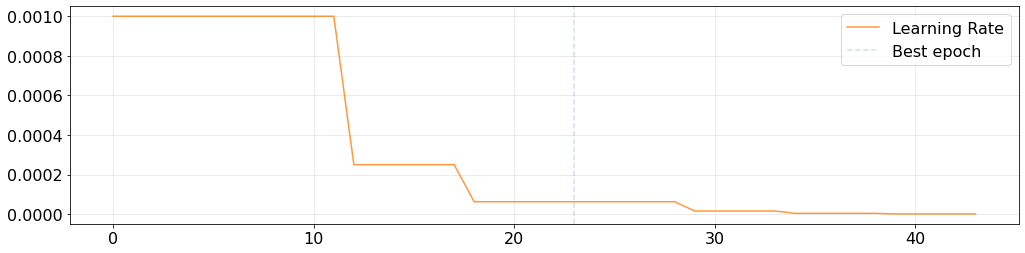

In [109]:
plot_training_history(history)

12/12 [==============================] - 0s 4ms/step
Accuracy: 0.8301
Precision: 0.8506
Recall: 0.7322
F1: 0.7702


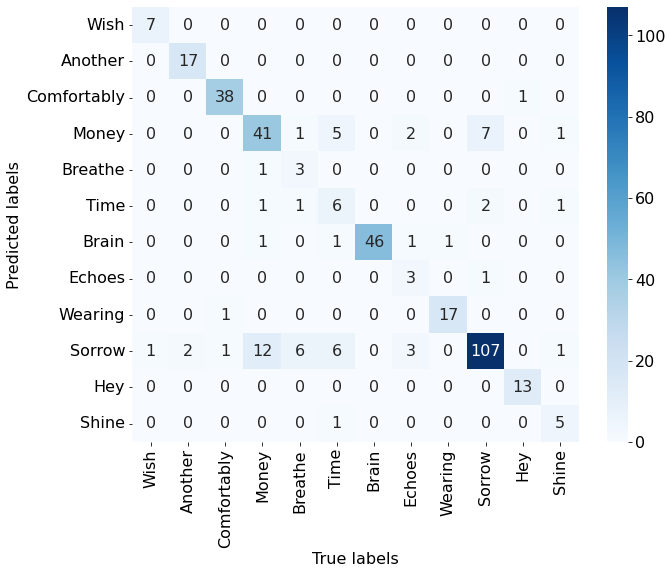

In [110]:
predict_plot_cm(aug_os_cnn_l2_patience_model, x_test, test_labels)

In [112]:
aug_os_cnn_l2_patience_model.save('challenge2/Aug_OS_CNN_128_L2_P.h5')

### Custom CNN

In [48]:
def customCNN_classifier(input_shape, classes):

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    x = tfkl.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(input_layer)
    x = tfkl.MaxPooling1D(pool_size=2, strides=2)(x)
    x = tfkl.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
    x = tfkl.MaxPooling1D(pool_size=2, strides=2)(x)
    cnn = tfkl.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(x)
    cnn = tfkl.GlobalAveragePooling1D()(cnn)
    classifier = tfkl.Dense(512, activation='relu')(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(classifier)
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    dropout = tfkl.Dropout(.5, seed=seed)(classifier)
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    dropout = tfkl.Dropout(.5, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model

In [128]:
aug_os_customcnn_model = customCNN_classifier(input_shape, classes)
aug_os_customcnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_47 (Conv1D)          (None, 36, 128)           2432      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 18, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_48 (Conv1D)          (None, 18, 256)           98560     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 9, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_49 (Conv1D)          (None, 9, 512)            393728

In [129]:
# Train the model
history = aug_os_customcnn_model.fit(
    x = aug_os_train,
    y = aug_os_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.25, min_lr=1e-6)
    ]
).history

Epoch 1/500
123/123 [==============================] - 2s 9ms/step - loss: 7.6440 - accuracy: 0.1977 - val_loss: 2.3484 - val_accuracy: 0.3562 - lr: 0.0010
Epoch 2/500
123/123 [==============================] - 1s 6ms/step - loss: 2.0758 - accuracy: 0.2935 - val_loss: 2.1870 - val_accuracy: 0.3945 - lr: 0.0010
Epoch 3/500
123/123 [==============================] - 1s 6ms/step - loss: 1.8291 - accuracy: 0.3831 - val_loss: 2.1246 - val_accuracy: 0.4192 - lr: 0.0010
Epoch 4/500
123/123 [==============================] - 1s 6ms/step - loss: 1.6113 - accuracy: 0.4613 - val_loss: 1.8438 - val_accuracy: 0.3753 - lr: 0.0010
Epoch 5/500
123/123 [==============================] - 1s 6ms/step - loss: 1.4885 - accuracy: 0.5026 - val_loss: 1.9239 - val_accuracy: 0.3342 - lr: 0.0010
Epoch 6/500
123/123 [==============================] - 1s 6ms/step - loss: 1.3249 - accuracy: 0.5486 - val_loss: 1.6232 - val_accuracy: 0.4274 - lr: 0.0010
Epoch 7/500
123/123 [==============================] - 1s 6ms/st

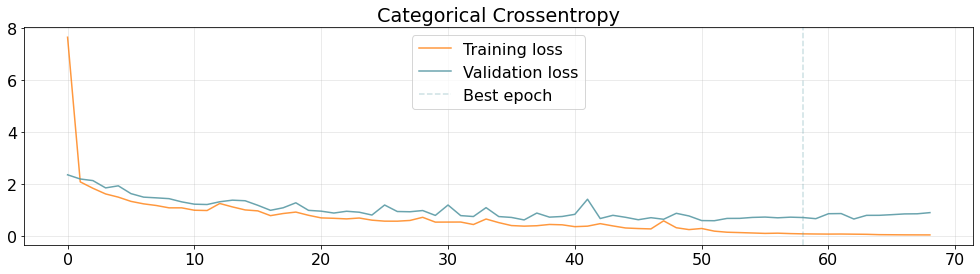

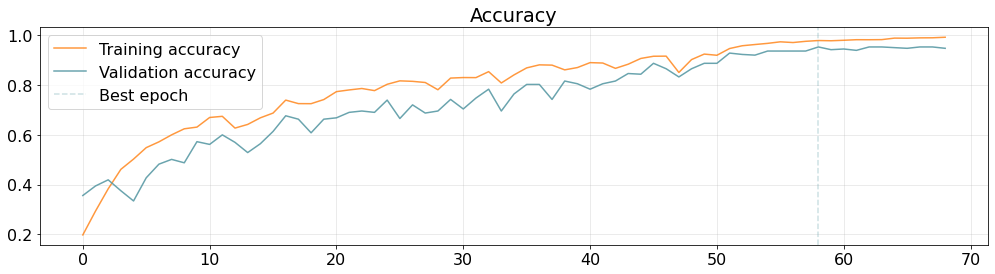

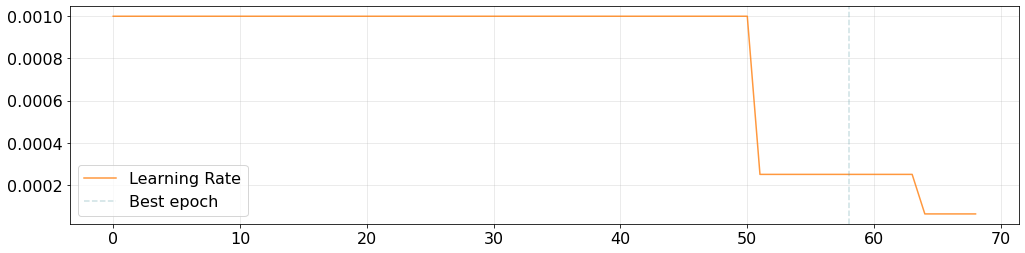

In [130]:
plot_training_history(history)

12/12 [==============================] - 0s 7ms/step
Accuracy: 0.9534
Precision: 0.9604
Recall: 0.9344
F1: 0.9463


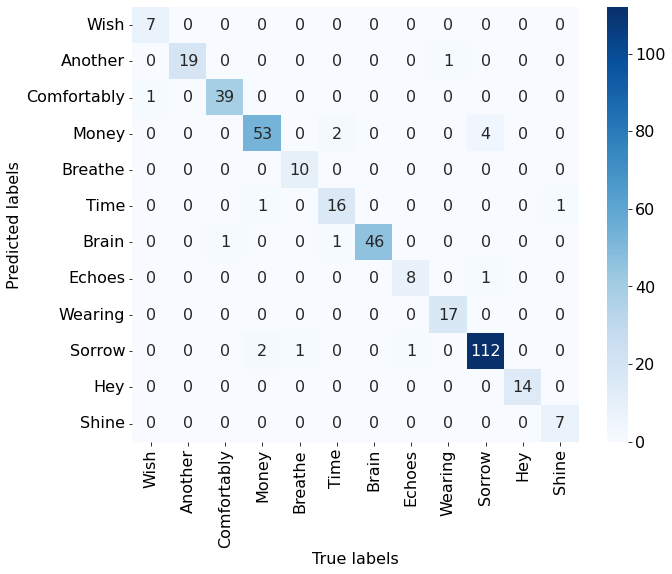

In [131]:
predict_plot_cm(aug_os_customcnn_model, x_test, test_labels)

In [133]:
aug_os_customcnn_model.save('challenge2/Aug_OS_CustomCNN_128')

## Augment, Oversample and Scale

In [81]:
# Augment
x_aug = scaling(jitter(x_train))
aug_x_train = np.concatenate((x_train, x_aug))
aug_train_labels = np.concatenate((train_labels, train_labels))

In [82]:
# Reshape array
reshaped_x_train, reshaped_train_labels = reshape_array(aug_x_train, aug_train_labels)
smote = SMOTE(random_state=seed)
os_x_train, os_train_labels = smote.fit_resample(reshaped_x_train, reshaped_train_labels)
print('Oversampled Train Data:', os_x_train.shape)
print('Oversampled Train Target:', os_train_labels.shape)

Input Data Shape: (4128, 36, 6)
Input Labels Shape: (4128, 12)
Reshaped Data: (148608, 6)
Reshaped Labels: (148608, 12)
Oversampled Train Data: (570240, 6)
Oversampled Train Target: (570240, 12)


In [83]:
# Scale data
standard_scaler = StandardScaler()
ss_aug_os_train = standard_scaler.fit_transform(os_x_train)
# Apply similar scaling to test data
reshaped_x_test, reshaped_test_labels = reshape_array(x_test, test_labels)
ss_aug_os_test = standard_scaler.transform(reshaped_x_test)

Input Data Shape: (365, 36, 6)
Input Labels Shape: (365, 12)
Reshaped Data: (13140, 6)
Reshaped Labels: (13140, 12)


{0: 47520, 1: 47520, 2: 47520, 3: 47520, 4: 47520, 5: 47520, 6: 47520, 7: 47520, 8: 47520, 9: 47520, 10: 47520, 11: 47520}


([<matplotlib.axis.XTick at 0x7fabefe1d490>,
 <a list of 12 Text major ticklabel objects>)

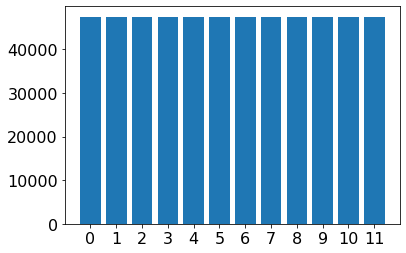

In [84]:
data, counts_data = np.unique(np.argmax(os_train_labels, axis=1), return_counts=True)
class_freq = dict(zip(data, counts_data))
print(class_freq)
plt.bar(list(class_freq.keys()),list(class_freq.values()))
plt.xticks(np.arange(12))

In [85]:
# Restore array shape
aug_os_ss_train, aug_os_ss_train_labels = restore_array_shape(ss_aug_os_train, os_train_labels)
aug_os_ss_test, aug_os_ss_test_labels = restore_array_shape(ss_aug_os_test, reshaped_test_labels)

Input Data Shape: (570240, 6)
Input Labels Shape: (570240, 12)
Restored Data: (15840, 36, 6)
Restored Labels: (15840, 12)
Input Data Shape: (13140, 6)
Input Labels Shape: (13140, 12)
Restored Data: (365, 36, 6)
Restored Labels: (365, 12)


### LSTM Model

In [86]:
aug_os_ss_lstm_model = build_LSTM_classifier(input_shape, classes)
aug_os_ss_lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_20 (LSTM)              (None, 36, 128)           69120     
                                                                 
 lstm_21 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               16512     
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 12)                780   

In [87]:
# Train the model
history = aug_os_ss_lstm_model.fit(
    x = aug_os_ss_train,
    y = aug_os_ss_train_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(aug_os_ss_test, aug_os_ss_test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.25, min_lr=1e-6)
    ]
).history

Epoch 1/500
124/124 [==============================] - 5s 15ms/step - loss: 1.7901 - accuracy: 0.3603 - val_loss: 2.0878 - val_accuracy: 0.2274 - lr: 0.0010
Epoch 2/500
124/124 [==============================] - 1s 9ms/step - loss: 1.3262 - accuracy: 0.5274 - val_loss: 1.9897 - val_accuracy: 0.2247 - lr: 0.0010
Epoch 3/500
124/124 [==============================] - 1s 9ms/step - loss: 1.2506 - accuracy: 0.5540 - val_loss: 2.0655 - val_accuracy: 0.2301 - lr: 0.0010
Epoch 4/500
124/124 [==============================] - 1s 9ms/step - loss: 1.1446 - accuracy: 0.5907 - val_loss: 2.2439 - val_accuracy: 0.1726 - lr: 0.0010
Epoch 5/500
124/124 [==============================] - 1s 9ms/step - loss: 1.0763 - accuracy: 0.6199 - val_loss: 1.8633 - val_accuracy: 0.3726 - lr: 0.0010
Epoch 6/500
124/124 [==============================] - 1s 9ms/step - loss: 1.0304 - accuracy: 0.6392 - val_loss: 1.7370 - val_accuracy: 0.3616 - lr: 0.0010
Epoch 7/500
124/124 [==============================] - 1s 9ms/s

12/12 [==============================] - 1s 4ms/step
Accuracy: 0.5726
Precision: 0.5013
Recall: 0.4548
F1: 0.4644


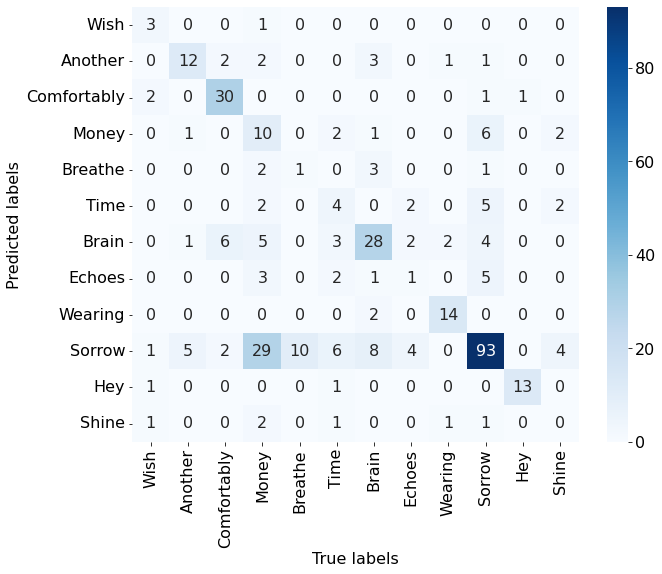

In [88]:
predict_plot_cm(aug_os_ss_lstm_model, aug_os_ss_test, aug_os_ss_test_labels)

### BiLSTM Model

In [89]:
aug_os_ss_bilstm_model = build_BiLSTM_classifier(input_shape, classes)
aug_os_ss_bilstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 36, 256)          138240    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                16448     
                                                                 
 dense_35 (Dense)            (None, 12)                780   

In [90]:
# Train the model
history = aug_os_ss_bilstm_model.fit(
    x = aug_os_ss_train,
    y = aug_os_ss_train_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(aug_os_ss_test, aug_os_ss_test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.25, min_lr=1e-6)
    ]
).history

Epoch 1/500
124/124 [==============================] - 9s 26ms/step - loss: 1.6218 - accuracy: 0.4132 - val_loss: 2.0825 - val_accuracy: 0.1425 - lr: 0.0010
Epoch 2/500
124/124 [==============================] - 2s 15ms/step - loss: 1.2650 - accuracy: 0.5350 - val_loss: 1.9167 - val_accuracy: 0.3178 - lr: 0.0010
Epoch 3/500
124/124 [==============================] - 2s 15ms/step - loss: 1.1245 - accuracy: 0.5890 - val_loss: 1.9296 - val_accuracy: 0.2493 - lr: 0.0010
Epoch 4/500
124/124 [==============================] - 2s 15ms/step - loss: 1.0395 - accuracy: 0.6177 - val_loss: 1.9973 - val_accuracy: 0.2164 - lr: 0.0010
Epoch 5/500
124/124 [==============================] - 2s 15ms/step - loss: 0.9806 - accuracy: 0.6424 - val_loss: 1.7483 - val_accuracy: 0.3397 - lr: 0.0010
Epoch 6/500
124/124 [==============================] - 2s 15ms/step - loss: 0.9654 - accuracy: 0.6473 - val_loss: 1.6931 - val_accuracy: 0.4055 - lr: 0.0010
Epoch 7/500
124/124 [==============================] - 2s 

12/12 [==============================] - 1s 7ms/step
Accuracy: 0.5836
Precision: 0.4872
Recall: 0.4638
F1: 0.4664


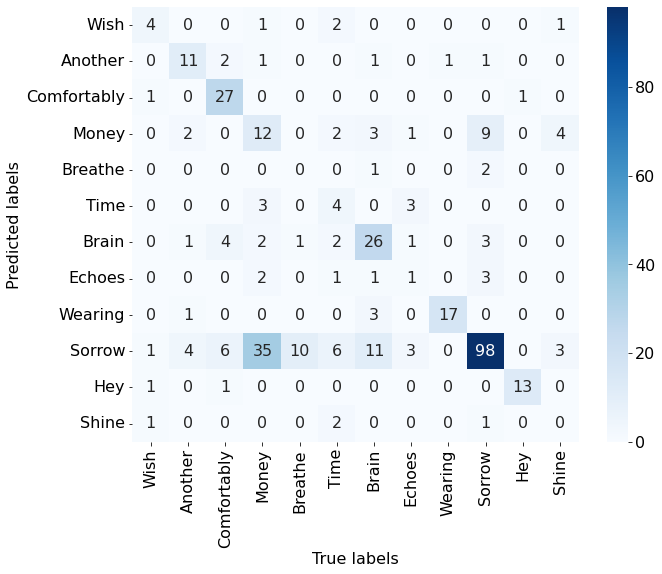

In [91]:
predict_plot_cm(aug_os_ss_bilstm_model, aug_os_ss_test, aug_os_ss_test_labels)

# Correlation

In [14]:
reshaped_x_train, restored_train_labels = reshape_array(x_train, train_labels)

Input Data Shape: (1943, 36, 6)
Input Labels Shape: (1943, 12)
Reshaped Data: (69948, 6)
Reshaped Labels: (69948, 12)


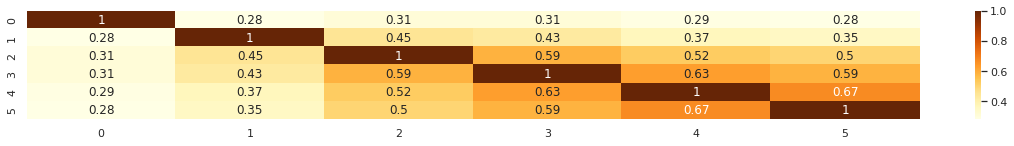

In [23]:
sns.set(rc = {'figure.figsize':(20,2)})
sns.heatmap(pd.DataFrame(reshaped_x_train).corr(), annot = True, fmt='.2g',cmap= 'YlOrBr')

In [35]:
new_arr = np.concatenate((reshaped_x_train, reshaped_x_train.mean(axis=1, keepdims=True)), axis=1)

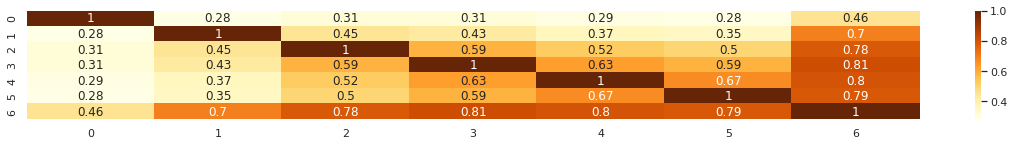

In [38]:
sns.set(rc = {'figure.figsize':(20,2)})
sns.heatmap(pd.DataFrame(new_arr).corr(), annot = True, fmt='.2g',cmap= 'YlOrBr')

In [39]:
new_x_train, train_labels = restore_array_shape(new_arr, restored_train_labels)

Input Data Shape: (69948, 7)
Input Labels Shape: (69948, 12)
Restored Data: (1943, 36, 7)
Restored Labels: (1943, 12)


In [40]:
# Apply similar changes to validation/test data
reshaped_x_test, restored_test_labels = reshape_array(x_test, test_labels)
new_test = np.concatenate((reshaped_x_test, reshaped_x_test.mean(axis=1, keepdims=True)), axis=1)
new_x_test, test_labels = restore_array_shape(new_test, restored_test_labels)

Input Data Shape: (486, 36, 6)
Input Labels Shape: (486, 12)
Reshaped Data: (17496, 6)
Reshaped Labels: (17496, 12)
Input Data Shape: (17496, 7)
Input Labels Shape: (17496, 12)
Restored Data: (486, 36, 7)
Restored Labels: (486, 12)


In [41]:
new_feat_bilstm_model = build_BiLSTM_classifier(new_x_train.shape[1:], classes)
new_feat_bilstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 7)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 256)          139264    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 12)                780   

In [42]:
# Train the model
history = new_feat_bilstm_model.fit(
    x = new_x_train,
    y = train_labels,
    batch_size = 64,
    epochs = epochs,
    validation_data=(new_x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/500
16/16 [==============================] - 13s 123ms/step - loss: 2.1008 - accuracy: 0.3448 - val_loss: 1.7459 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 2/500
16/16 [==============================] - 0s 18ms/step - loss: 1.6018 - accuracy: 0.4822 - val_loss: 1.5154 - val_accuracy: 0.4547 - lr: 0.0010
Epoch 3/500
16/16 [==============================] - 0s 19ms/step - loss: 1.3485 - accuracy: 0.5337 - val_loss: 1.3279 - val_accuracy: 0.5329 - lr: 0.0010
Epoch 4/500
16/16 [==============================] - 0s 18ms/step - loss: 1.1813 - accuracy: 0.6068 - val_loss: 1.2161 - val_accuracy: 0.5782 - lr: 0.0010
Epoch 5/500
16/16 [==============================] - 0s 18ms/step - loss: 1.0677 - accuracy: 0.6459 - val_loss: 1.1001 - val_accuracy: 0.6173 - lr: 0.0010
Epoch 6/500
16/16 [==============================] - 0s 18ms/step - loss: 0.9606 - accuracy: 0.6665 - val_loss: 1.1518 - val_accuracy: 0.6091 - lr: 0.0010
Epoch 7/500
16/16 [==============================] - 0s 20ms/step - 

16/16 [==============================] - 1s 7ms/step
Accuracy: 0.6831
Precision: 0.6524
Recall: 0.5686
F1: 0.5798


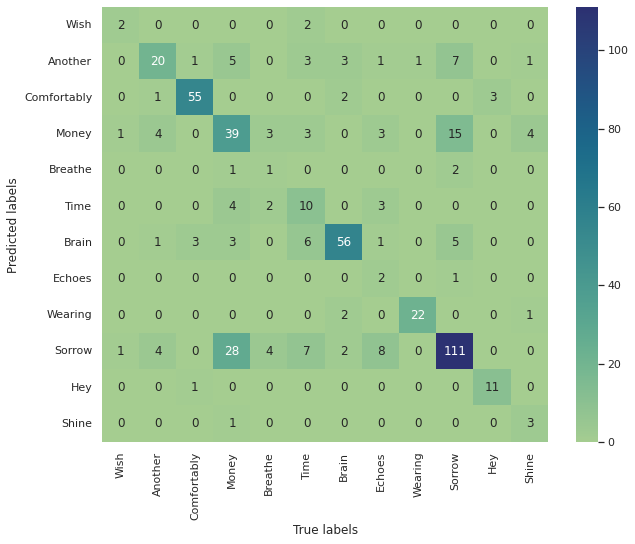

In [43]:
predict_plot_cm(new_feat_bilstm_model, new_x_test, test_labels)

# Subset of features

In [21]:
reshaped_x_train, restored_train_labels = reshape_array(x_train, train_labels)

Input Data Shape: (1943, 36, 6)
Input Labels Shape: (1943, 12)
Reshaped Data: (69948, 6)
Reshaped Labels: (69948, 12)


In [44]:
subset_train = reshaped_x_train[:, 2:]
subset_train.shape

(69948, 4)

In [45]:
subset_x_train, train_labels = restore_array_shape(subset_train, restored_train_labels)

Input Data Shape: (69948, 4)
Input Labels Shape: (69948, 12)
Restored Data: (1943, 36, 4)
Restored Labels: (1943, 12)


In [46]:
# Apply similar changes to validation/test data
reshaped_x_test, restored_test_labels = reshape_array(x_test, test_labels)
subset_test = reshaped_x_test[:, 2:]
subset_x_test, test_labels = restore_array_shape(subset_test, restored_test_labels)

Input Data Shape: (486, 36, 6)
Input Labels Shape: (486, 12)
Reshaped Data: (17496, 6)
Reshaped Labels: (17496, 12)
Input Data Shape: (17496, 4)
Input Labels Shape: (17496, 12)
Restored Data: (486, 36, 4)
Restored Labels: (486, 12)


In [47]:
subfeat_bilstm_model = build_BiLSTM_classifier(subset_x_train.shape[1:], classes)
subfeat_bilstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 4)]           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 36, 256)          136192    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                16448     
                                                                 
 dense_14 (Dense)            (None, 12)                780   

In [48]:
# Train the model
history = subfeat_bilstm_model.fit(
    x = subset_x_train,
    y = train_labels,
    batch_size = 128,
    epochs = epochs,
    validation_data=(subset_x_test, test_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/500
16/16 [==============================] - 7s 112ms/step - loss: 2.0765 - accuracy: 0.3284 - val_loss: 1.7607 - val_accuracy: 0.4403 - lr: 0.0010
Epoch 2/500
16/16 [==============================] - 0s 20ms/step - loss: 1.6577 - accuracy: 0.4591 - val_loss: 1.5035 - val_accuracy: 0.4733 - lr: 0.0010
Epoch 3/500
16/16 [==============================] - 0s 21ms/step - loss: 1.4144 - accuracy: 0.5296 - val_loss: 1.3390 - val_accuracy: 0.5226 - lr: 0.0010
Epoch 4/500
16/16 [==============================] - 0s 22ms/step - loss: 1.2703 - accuracy: 0.5775 - val_loss: 1.2524 - val_accuracy: 0.5658 - lr: 0.0010
Epoch 5/500
16/16 [==============================] - 0s 21ms/step - loss: 1.1675 - accuracy: 0.6119 - val_loss: 1.1807 - val_accuracy: 0.5967 - lr: 0.0010
Epoch 6/500
16/16 [==============================] - 0s 21ms/step - loss: 1.0921 - accuracy: 0.6258 - val_loss: 1.1346 - val_accuracy: 0.6070 - lr: 0.0010
Epoch 7/500
16/16 [==============================] - 0s 22ms/step - l

16/16 [==============================] - 2s 7ms/step
Accuracy: 0.6502
Precision: 0.609
Recall: 0.5414
F1: 0.5586


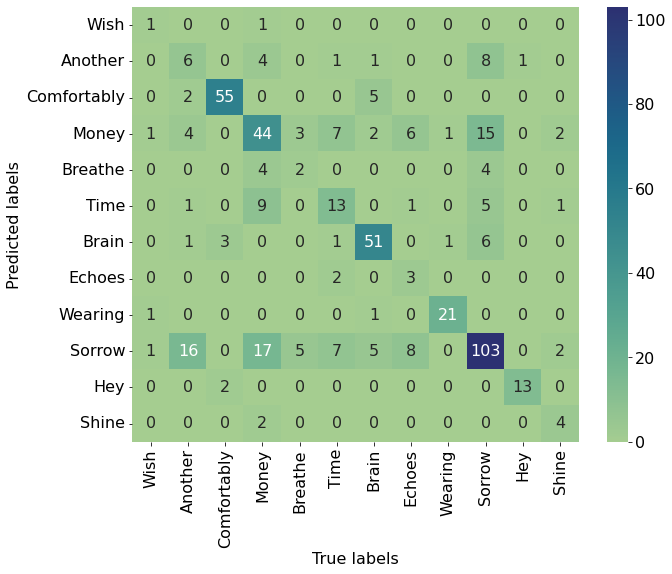

In [49]:
predict_plot_cm(subfeat_bilstm_model, subset_x_test, test_labels)

# Ensemble

In [44]:
model1 = tfk.models.load_model('challenge2/LSTM_16_L2')
model2 = tfk.models.load_model('challenge2/BiLSTM_16_L2')
model3 = tfk.models.load_model('challenge2/Aug_BiLSTM_16_L2')
model4 = tfk.models.load_model('challenge2/OS_BiLSTM_128_L2')
model5 = tfk.models.load_model('challenge2/Aug_OS_BiLSTM_128_L2')
model6 = tfk.models.load_model('challenge2/Aug_OS_CustomCNN_128')

In [45]:
pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)
pred3 = model3.predict(x_test)
pred4 = model4.predict(x_test)
pred5 = model5.predict(x_test)
pred6 = model6.predict(x_test)


pred = pred1 + pred2 + pred3 + pred4 + pred5 + pred6
final_pred = tf.argmax(pred, axis=-1)

12/12 [==============================] - 0s 3ms/step


Accuracy: 0.9753
Precision: 0.9848
Recall: 0.967
F1: 0.9751


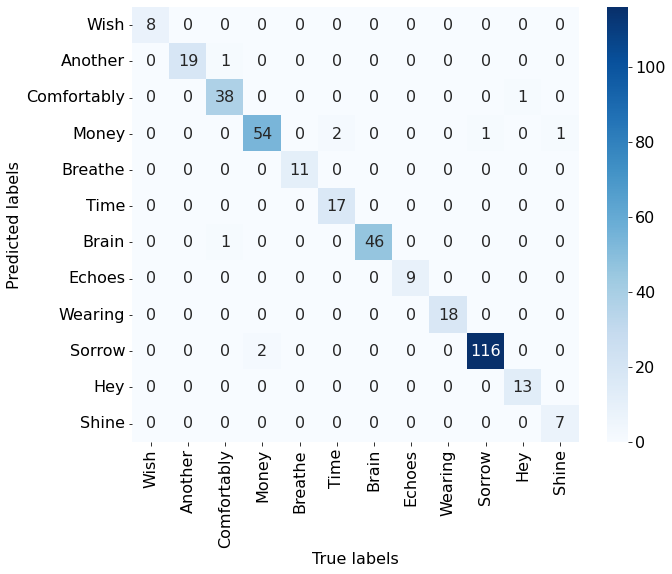

In [46]:
cm = confusion_matrix(np.argmax(test_labels, axis=-1), np.argmax(pred, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(test_labels, axis=-1), np.argmax(pred, axis=-1))
precision = precision_score(np.argmax(test_labels, axis=-1), np.argmax(pred, axis=-1), average='macro')
recall = recall_score(np.argmax(test_labels, axis=-1), np.argmax(pred, axis=-1), average='macro')
f1 = f1_score(np.argmax(test_labels, axis=-1), np.argmax(pred, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(labels.keys()), yticklabels=list(labels.keys()), annot=True, fmt='')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [38]:
members = [model1, model2, model3, model4, model5, model6]
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, x_test):
 # make predictions
 yhats = [model.predict(x_test) for model in members]
 yhats = np.array(yhats)
 # sum across ensemble members
 summed = np.sum(yhats, axis=0)
 # argmax across classes
 result = np.argmax(summed, axis=1)
 return result


# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
 # select a subset of members
 subset = members[:n_members]
 print(len(subset))
 rounded_labels=np.argmax(testy, axis=1)
 # make prediction
 yhat = ensemble_predictions(subset, testX)
 # calculate accuracy
 return accuracy_score(rounded_labels, yhat)

1
12/12 [==============================] - 0s 4ms/step
> 0.953
2
12/12 [==============================] - 0s 6ms/step
> 0.953
3
12/12 [==============================] - 0s 7ms/step
> 0.962
4
12/12 [==============================] - 0s 7ms/step
> 0.964
5
12/12 [==============================] - 0s 7ms/step
> 0.967
6
12/12 [==============================] - 0s 2ms/step
> 0.975


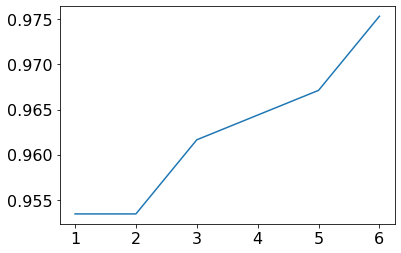

In [47]:
n_members=6
scores = []
for i in range(1, n_members+1):
 score = evaluate_n_members(members, i, x_test, test_labels)
 print('> %.3f' % score)
 scores.append(score)
# plot score vs number of ensemble members
x_axis = [i for i in range(1, n_members+1)]
plt.plot(x_axis, scores)
plt.show()